# Notebook Overview & Goals

This notebook serves as a comprehensive, end-to-end pipeline for analyzing the interaction between M31 and M33 in a cosmological context. Specifically, it will:

- **Read** the snapshot data for both M31 and M33 at various times.
- **Compute** key parameters such as the Jacobi (tidal) radius and bound mass of M33 to understand its mass-loss history.
- **Generate** surface density profiles of M33’s stellar disk and fit Sersic or exponential profiles over time.
- **Analyze** morphological features of M33 (e.g., spiral arms, warping, scale height) by rotating its coordinate system into face-on and edge-on views.
- **Compare** these results to theoretical models for tidal interactions and disk evolution, with an eye toward how mass loss correlates with morphological changes.

Ultimately, the outputs from this notebook (plots, tables, best-fit parameters, etc.) will form the quantitative backbone of a 5–6 page final research paper, giving us both the raw data and visual diagnostics to draw robust scientific conclusions.


In [1]:
# Cell 1.1: Imports & Logging Configuration

# -------------------------
# Standard Python imports
import numpy as np
import matplotlib.pyplot as plt
import logging
import sys

# Optional: Astropy or SciPy if needed
import astropy.units as u
from astropy import constants as const
from scipy.optimize import curve_fit
# etc. for any other modules you anticipate using

# -------------------------
# Configure logging
logging.basicConfig(
    level=logging.INFO,             # Choose DEBUG, INFO, WARNING, ERROR as needed
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout),
        # Could add a file handler if you want logs saved to a file:
        # logging.FileHandler('notebook_log.txt', mode='w')
    ]
)

# Example of logging usage
logging.info("Notebook started. Libraries imported successfully.")

# -------------------------
# Global constants (example)
G_kpcGyrMsun = 4.499e-6  # Gravitational constant in kpc^3 / Gyr^2 / Msun
M31_halo_mass = 1.5e12   # Msun, total halo mass for M31
M31_scale_radius = 60.0  # kpc, Hernquist scale radius for M31

# We’ll expand or modify these as needed in subsequent cells.
print("Cell 1.1 completed: Libraries and logging configured.")


2025-04-01 00:35:21,029 [INFO] Notebook started. Libraries imported successfully.
Cell 1.1 completed: Libraries and logging configured.


In [2]:
# Cell 1.2: User-Configurable Parameters & Filenames

# ---------------------------------------------------------------------
# Directories for snapshot files
# Provide the paths to where M31_000.txt, M33_000.txt, etc. reside.
M31_DIRECTORY = "M31/"  # e.g., "data/M31/" or an absolute path
M33_DIRECTORY = "M33/"  # e.g., "data/M33/" or an absolute path

# Snapshots might also have consistent naming, like M31_000.txt, M31_001.txt, etc.
# If there's a different naming scheme, specify here or in parse functions.

# ---------------------------------------------------------------------
# Tidal / mass-loss configuration
ROUTER_LIMIT = 300.0   # Max radius for bound mass check (kpc)
                     # We'll take min(R_jacobi, ROUTER_LIMIT) when summing bound mass.

# ---------------------------------------------------------------------
# Surface density profile configuration
NBINS_PROFILES = 300   # Number of radial bins (annuli) for the surface density computation
RMAX_PROFILES  = 300.0 # kpc out to which we compute the radial profile

# ---------------------------------------------------------------------
# Additional config variables 
# (You can add or remove as needed throughout the analysis)
M31_HALO_MASS   = 1.5e12   # Msun, total halo mass for M31 if using Hernquist
M31_SCALE_RADIUS = 60.0    # kpc, scale radius for M31's Hernquist profile

# Data logging or output options
SAVE_INTERMEDIATE_RESULTS = True  # If True, we’ll save .npy/.txt files at various steps
PLOTS_DIRECTORY           = "plots/"   # Where to store generated plots
RESULTS_DIRECTORY         = "results/" # Where to store numeric outputs

# ---------------------------------------------------------------------
# Print for user confirmation
print("Cell 1.2 completed: User-configurable parameters and filenames set.")
print(f"M31 files assumed to be in: {M31_DIRECTORY}")
print(f"M33 files assumed to be in: {M33_DIRECTORY}")
print(f"Router limit for bound mass: {ROUTER_LIMIT} kpc")
print(f"Surface density profile: {NBINS_PROFILES} radial bins, rmax={RMAX_PROFILES} kpc")


Cell 1.2 completed: User-configurable parameters and filenames set.
M31 files assumed to be in: M31/
M33 files assumed to be in: M33/
Router limit for bound mass: 300.0 kpc
Surface density profile: 300 radial bins, rmax=300.0 kpc


In [3]:
# ---------------------------------------------------------------
# Cell 2.1 — "File Parsing Functions"
# Type: Code
# ---------------------------------------------------------------

import logging
import re  # if we need to parse snapshot indices from filenames

def parse_galaxy_file(filename):
    """
    Reads a galaxy snapshot file (e.g., M31_000.txt or M33_010.txt)
    and returns:
        time_val        : float
            Time in Gyr from the file header (line with 'Time')
        total_particles : int
            Number of particles from the file header (line with 'Total')
        data_tuple      : tuple of np.ndarrays
            (ptype, pmass, x, y, z, vx, vy, vz)

    Each data line in the file is assumed to have the columns:
       #type, mass(1e10 Msun), x(kpc), y(kpc), z(kpc),
       vx(km/s), vy(km/s), vz(km/s)

    Column details:
    1) type : float or int indicating particle type (e.g., 1.0 for dark matter, 2.0 for disk, etc.)
    2) mass : float, in units of 1e10 solar masses
    3) x, y, z : floats, positions in kpc
    4) vx, vy, vz : floats, velocities in km/s

    Parameters
    ----------
    filename : str
        Path to the snapshot file to read.

    Returns
    -------
    time_val : float
        Time (Gyr) of the snapshot from file header.
    total_particles : int
        Number of particles in the snapshot (from header).
    data_tuple : (ptype, pmass, x, y, z, vx, vy, vz)
        Each element is a NumPy array of length total_particles.
    """
    time_val = None
    total_particles = None

    # Lists to store data columns
    ptype_list = []
    mass_list  = []
    x_list     = []
    y_list     = []
    z_list     = []
    vx_list    = []
    vy_list    = []
    vz_list    = []

    # Read the file
    with open(filename, 'r') as f:
        lines = f.readlines()

    data_start_idx = None

    # Parse header lines
    for i, line in enumerate(lines):
        line_stripped = line.strip()
        # e.g. "Time      0.00000"
        if line_stripped.startswith("Time"):
            parts = line_stripped.split()
            time_val = float(parts[1])
        elif line_stripped.startswith("Total"):
            parts = line_stripped.split()
            total_particles = int(parts[1])
        elif line_stripped.startswith("#type"):
            data_start_idx = i + 1
            break

    if data_start_idx is None:
        logging.warning(f"parse_galaxy_file: No data header ('#type') found in {filename}")
        return None, None, (None,)*8

    # Parse data lines
    for line in lines[data_start_idx:]:
        line_stripped = line.strip()
        if not line_stripped:
            continue
        parts = line_stripped.split()
        if len(parts) < 8:
            # Possibly an empty or invalid line, skip
            continue

        # Extract columns
        ptype = float(parts[0])  # e.g. 1.0, 2.0, 3.0
        pmass = float(parts[1])
        px    = float(parts[2])
        py    = float(parts[3])
        pz    = float(parts[4])
        pvx   = float(parts[5])
        pvy   = float(parts[6])
        pvz   = float(parts[7])

        ptype_list.append(ptype)
        mass_list.append(pmass)
        x_list.append(px)
        y_list.append(py)
        z_list.append(pz)
        vx_list.append(pvx)
        vy_list.append(pvy)
        vz_list.append(pvz)

    import numpy as np
    ptype_array = np.array(ptype_list)
    mass_array  = np.array(mass_list)
    x_array     = np.array(x_list)
    y_array     = np.array(y_list)
    z_array     = np.array(z_list)
    vx_array    = np.array(vx_list)
    vy_array    = np.array(vy_list)
    vz_array    = np.array(vz_list)

    if total_particles is not None and len(ptype_array) != total_particles:
        logging.warning(f"parse_galaxy_file: Mismatch in count. Header says {total_particles}, "
                        f"but we read {len(ptype_array)} lines of data in {filename}")

    logging.info(f"Parsed file: {filename} | time={time_val} Gyr | total_particles={len(ptype_array)}")
    data_tuple = (ptype_array, mass_array, x_array, y_array, z_array, vx_array, vy_array, vz_array)
    return time_val, len(ptype_array), data_tuple


def get_snapshot_index(filename):
    """
    Extract snapshot index from a filename that might look like 'M31_003.txt'
    If we find an underscore followed by digits, we return that integer.
    If none found, return None.

    Example
    -------
    >>> get_snapshot_index("M31_003.txt")
    3
    >>> get_snapshot_index("M33_050.txt")
    50
    """
    match = re.search(r'_([0-9]+)\.txt', filename)
    if match:
        return int(match.group(1))
    else:
        return None


print("Cell 2.1 completed: parse_galaxy_file() and get_snapshot_index() defined in memory.")


Cell 2.1 completed: parse_galaxy_file() and get_snapshot_index() defined in memory.


In [4]:
# ---------------------------------------------------------------
# Cell 2.2 — "Center of Mass & Other Shared Math Routines"
# Type: Code
# ---------------------------------------------------------------

import numpy as np
import logging

def center_of_mass(x, y, z, mass):
    """
    Compute the center-of-mass for a set of particles with positions (x, y, z)
    and masses 'mass'.
    
    Parameters
    ----------
    x, y, z : np.array
        Positions in kpc (or any consistent unit).
    mass : np.array
        Mass of each particle (in e.g. 1e10 Msun units or Msun, but must be consistent).

    Returns
    -------
    xcom, ycom, zcom : float
        The coordinates of the center of mass in the same units as x, y, z.
    """
    M_total = np.sum(mass)
    if M_total == 0:
        logging.warning("center_of_mass: Total mass is zero. Returning (0,0,0).")
        return 0.0, 0.0, 0.0

    xcom = np.sum(x * mass) / M_total
    ycom = np.sum(y * mass) / M_total
    zcom = np.sum(z * mass) / M_total

    return xcom, ycom, zcom


def hernquist_enclosed_mass(r, M_halo=1.5e12, a=60.0):
    """
    Computes the enclosed mass for a Hernquist profile:
       M(r) = M_halo * [r^2 / (r + a)^2]

    Typically used to approximate M31's halo mass distribution.

    Parameters
    ----------
    r : float or np.array
        Radius (kpc).
    M_halo : float
        Total halo mass in Msun (default 1.5e12 Msun).
    a : float
        Scale radius in kpc (default 60 kpc).

    Returns
    -------
    M_enc : float or np.array
        Enclosed mass (Msun) at radius r.
    """
    # We assume r >= 0. If r is an array, this function
    # will handle it element-wise.
    r = np.array(r, ndmin=1)  # ensure array for safe math
    M_enc = M_halo * (r**2 / (r + a)**2)
    # If r was scalar, we might want to return a scalar
    if M_enc.size == 1:
        return M_enc[0]
    return M_enc


def distance_3d(x1, y1, z1, x2, y2, z2):
    """
    Simple helper function to compute 3D distance between two points (x1,y1,z1) and (x2,y2,z2).
    Returns the distance in the same unit as x,y,z input.
    """
    dx = x2 - x1
    dy = y2 - y1
    dz = z2 - z1
    return np.sqrt(dx*dx + dy*dy + dz*dz)


def vector_magnitude(x, y, z):
    """
    Returns sqrt(x^2 + y^2 + z^2), useful for computing radii, velocity magnitude, etc.
    If x,y,z are np.arrays, does element-wise operation.
    """
    return np.sqrt(x*x + y*y + z*z)


print("Cell 2.2 completed: center_of_mass(), hernquist_enclosed_mass(), distance_3d(), vector_magnitude() defined.")


Cell 2.2 completed: center_of_mass(), hernquist_enclosed_mass(), distance_3d(), vector_magnitude() defined.


In [5]:
# ---------------------------------------------------------------
# Cell 2.3 — "Diagnostic Test: Single Snapshot Parsing & Printout"
# Type: Code
# ---------------------------------------------------------------

import os

# We'll use the user-configurable directories from Cell 1.2:
#   M31_DIRECTORY, M33_DIRECTORY
# We'll read e.g. M31_000.txt, M33_000.txt to do a quick test.

# Let's define a small function that tries the first snapshot for M31 and M33.

def diagnostic_test_single_snapshot(snapshot_index=0):
    """
    Parses a single M31 and M33 snapshot (e.g. M31_000.txt, M33_000.txt),
    prints out some basic info: time, number of particles, center-of-mass, etc.
    """
    from IPython.display import display
    import logging

    # Construct filenames
    file_m31 = f"{M31_DIRECTORY}M31_{snapshot_index:03d}.txt"
    file_m33 = f"{M33_DIRECTORY}M33_{snapshot_index:03d}.txt"

    if not (os.path.exists(file_m31) and os.path.exists(file_m33)):
        logging.warning(f"Cannot find M31 or M33 snapshot for index={snapshot_index}")
        return

    # Parse M31
    t_m31, count_m31, (ptype_m31, mass_m31, x_m31, y_m31, z_m31, vx_m31, vy_m31, vz_m31) = parse_galaxy_file(file_m31)
    # Parse M33
    t_m33, count_m33, (ptype_m33, mass_m33, x_m33, y_m33, z_m33, vx_m33, vy_m33, vz_m33) = parse_galaxy_file(file_m33)

    # Print times
    print(f"\n=== Diagnostic Test for Snap Index {snapshot_index:03d} ===")
    print(f" M31: time={t_m31} Gyr, total_particles={count_m31}")
    print(f" M33: time={t_m33} Gyr, total_particles={count_m33}")

    # Compute COM for M31
    from math import isnan
    xcom_m31, ycom_m31, zcom_m31 = center_of_mass(x_m31, y_m31, z_m31, mass_m31)
    xcom_m33, ycom_m33, zcom_m33 = center_of_mass(x_m33, y_m33, z_m33, mass_m33)

    print(f" M31 COM: ({xcom_m31:.3f}, {ycom_m31:.3f}, {zcom_m31:.3f}) kpc")
    print(f" M33 COM: ({xcom_m33:.3f}, {ycom_m33:.3f}, {zcom_m33:.3f}) kpc")

    # Quick total mass check (in 1e10 Msun units for the file).
    # Typically, we multiply by 1e10 to get Msun.
    m31_total_mass = mass_m31.sum() * 1e10
    m33_total_mass = mass_m33.sum() * 1e10
    print(f" M31 total mass (raw sum): {m31_total_mass:.2e} Msun")
    print(f" M33 total mass (raw sum): {m33_total_mass:.2e} Msun")

    # Confirm times should match or be very close
    if abs(t_m31 - t_m33) > 1e-3:
        logging.warning("Times for M31 vs. M33 in same snap index differ significantly!")

# Now let's call this test function for the default snapshot_index=0
diagnostic_test_single_snapshot(snapshot_index=0)

print("\nCell 2.3 completed: Single snapshot parsing & printout diagnostic ran.")


2025-04-01 00:35:37,433 [INFO] Parsed file: M31/M31_000.txt | time=0.0 Gyr | total_particles=94500
2025-04-01 00:35:37,505 [INFO] Parsed file: M33/M33_000.txt | time=0.0 Gyr | total_particles=14300

=== Diagnostic Test for Snap Index 000 ===
 M31: time=0.0 Gyr, total_particles=94500
 M33: time=0.0 Gyr, total_particles=14300
 M31 COM: (-376.189, 614.251, -279.369) kpc
 M33 COM: (-480.396, 494.588, -411.738) kpc
 M31 total mass (raw sum): 2.06e+12 Msun
 M33 total mass (raw sum): 1.96e+11 Msun

Cell 2.3 completed: Single snapshot parsing & printout diagnostic ran.


In [6]:
# ---------------------------------------------------------------
# Cell 3.1.1 — "Compute & Store Jacobi Radius for All Snapshots"
# Type: Code
# ---------------------------------------------------------------

import os
import glob
import numpy as np
import logging

def compute_jacobi_all_snaps(save_results=SAVE_INTERMEDIATE_RESULTS):
    """
    Loop over all M31/*.txt and M33/*.txt snapshot files, compute the Jacobi radius (R_j) for M33.

    Steps for each snapshot index:
    1) Identify matching snapshot files M31_xxx.txt, M33_xxx.txt
    2) Parse data and compute center-of-mass for M31 & M33
    3) Compute relative distance R = distance(M31_COM, M33_COM)
    4) Compute enclosed host mass: Mhost_enc = hernquist_enclosed_mass(R)
    5) Compute total M33 mass: M33_sat_mass = sum of M33 masses * 1e10 Msun
    6) Jacobi radius: R_j = R * (M33_sat_mass / (2 * Mhost_enc))^(1/3)

    Parameters
    ----------
    save_results : bool
        If True, saves the results as a .npy file in RESULTS_DIRECTORY

    Returns
    -------
    times_jacobi : np.ndarray
        Array of times (Gyr) for each snapshot
    rjacobi_arr  : np.ndarray
        Jacobi radii (kpc) for each snapshot
    """
    # We rely on the M31_DIRECTORY, M33_DIRECTORY from Cell 1.2
    # Also on parse_galaxy_file, center_of_mass, hernquist_enclosed_mass from earlier cells.
    
    m31_pattern = os.path.join(M31_DIRECTORY, "M31_*.txt")
    m33_pattern = os.path.join(M33_DIRECTORY, "M33_*.txt")

    m31_files = sorted(glob.glob(m31_pattern))
    m33_files = sorted(glob.glob(m33_pattern))

    # Helper function to get snapshot index from file name
    def get_snapidx(fname):
        return get_snapshot_index(fname)  # from Cell 2.1

    # Build dict: index -> filename for M31, M33
    m31_dict = {}
    for f in m31_files:
        idx = get_snapidx(f)
        if idx is not None:
            m31_dict[idx] = f

    m33_dict = {}
    for f in m33_files:
        idx = get_snapidx(f)
        if idx is not None:
            m33_dict[idx] = f

    # Find common snapshot indices
    common_indices = sorted(set(m31_dict.keys()) & set(m33_dict.keys()))
    if not common_indices:
        logging.warning("No matching snapshot indices found between M31 and M33 directories!")
        return np.array([]), np.array([])

    times_list = []
    rj_list    = []

    for snap_idx in common_indices:
        # Parse M31
        file_m31 = m31_dict[snap_idx]
        t_m31, count_m31, data_m31 = parse_galaxy_file(file_m31)
        (ptype_m31, mass_m31, x_m31, y_m31, z_m31, vx_m31, vy_m31, vz_m31) = data_m31

        # Parse M33
        file_m33 = m33_dict[snap_idx]
        t_m33, count_m33, data_m33 = parse_galaxy_file(file_m33)
        (ptype_m33, mass_m33, x_m33, y_m33, z_m33, vx_m33, vy_m33, vz_m33) = data_m33

        # We'll assume times are essentially the same for M31 & M33 in the same snapshot
        t_val = 0.5*(t_m31 + t_m33)

        # Center of mass for M31 & M33
        xcom_m31, ycom_m31, zcom_m31 = center_of_mass(x_m31, y_m31, z_m31, mass_m31)
        xcom_m33, ycom_m33, zcom_m33 = center_of_mass(x_m33, y_m33, z_m33, mass_m33)

        # Relative distance R
        dx = xcom_m33 - xcom_m31
        dy = ycom_m33 - ycom_m31
        dz = zcom_m33 - zcom_m31
        R  = np.sqrt(dx*dx + dy*dy + dz*dz)

        # Enclosed host mass from M31
        Mhost_enc = hernquist_enclosed_mass(R, M_halo=M31_HALO_MASS, a=M31_SCALE_RADIUS)

        # M33 total mass (in Msun)
        # file mass is in 1e10 Msun
        M33_sat_mass = np.sum(mass_m33) * 1e10

        # Jacobi radius
        # R_j = R * (M33_sat_mass / (2 * Mhost_enc))^(1/3)
        if Mhost_enc <= 0:
            logging.warning(f"compute_jacobi_all_snaps: Mhost_enc <= 0 for snap {snap_idx}, skipping.")
            continue
        R_j = R * ((M33_sat_mass / (2.0 * Mhost_enc)) ** (1.0/3.0))

        # Logging checks
        if R_j <= 0:
            logging.warning(f"Jacobi radius <= 0 for snap {snap_idx}. Possibly no M33 mass or Mhost_enc invalid.")
        if R_j > 300:
            logging.warning(f"Suspiciously large Jacobi radius (R_j={R_j:.2f} kpc) for snap {snap_idx} at time={t_val:.2f} Gyr.")

        logging.info(f"Snap {snap_idx:03d} | time={t_val:.3f} Gyr | R={R:.2f} kpc | R_j={R_j:.2f} kpc")

        times_list.append(t_val)
        rj_list.append(R_j)

    # Convert to arrays
    times_jacobi = np.array(times_list)
    rjacobi_arr  = np.array(rj_list)

    # Sort by time
    sort_idx = np.argsort(times_jacobi)
    times_jacobi = times_jacobi[sort_idx]
    rjacobi_arr  = rjacobi_arr[sort_idx]

    if save_results and len(times_jacobi) > 0:
        # Make sure the directory exists
        os.makedirs(RESULTS_DIRECTORY, exist_ok=True)  # Creates 'results/' if missing
        
        outfile = os.path.join(RESULTS_DIRECTORY, "jacobi_radius_vs_time.npy")
        np.save(outfile, np.column_stack((times_jacobi, rjacobi_arr)))
        logging.info(f"Jacobi radius results saved to {outfile}")

    return times_jacobi, rjacobi_arr


# Immediately run the function to fill in memory with results
times_jacobi, rjacobi_arr = compute_jacobi_all_snaps()
print("Cell 3.1.1 completed: Jacobi radius computed for all snapshots.")


2025-04-01 00:35:39,873 [INFO] Parsed file: M31/M31_000.txt | time=0.0 Gyr | total_particles=94500
2025-04-01 00:35:39,942 [INFO] Parsed file: M33/M33_000.txt | time=0.0 Gyr | total_particles=14300
2025-04-01 00:35:39,946 [INFO] Snap 000 | time=0.000 Gyr | R=206.64 kpc | R_j=98.63 kpc
2025-04-01 00:35:40,193 [INFO] Parsed file: M31/M31_001.txt | time=14.2857 Gyr | total_particles=94500
2025-04-01 00:35:40,260 [INFO] Parsed file: M33/M33_001.txt | time=14.2857 Gyr | total_particles=14300
2025-04-01 00:35:40,264 [INFO] Snap 001 | time=14.286 Gyr | R=204.61 kpc | R_j=97.80 kpc
2025-04-01 00:35:40,512 [INFO] Parsed file: M31/M31_002.txt | time=28.57142 Gyr | total_particles=94500
2025-04-01 00:35:40,575 [INFO] Parsed file: M33/M33_002.txt | time=28.57142 Gyr | total_particles=14300
2025-04-01 00:35:40,580 [INFO] Snap 002 | time=28.571 Gyr | R=202.57 kpc | R_j=96.98 kpc
2025-04-01 00:35:40,825 [INFO] Parsed file: M31/M31_003.txt | time=42.85712 Gyr | total_particles=94500
2025-04-01 00:35:4

Jacobi radius plot saved to plots/jacobi_radius_over_time.png


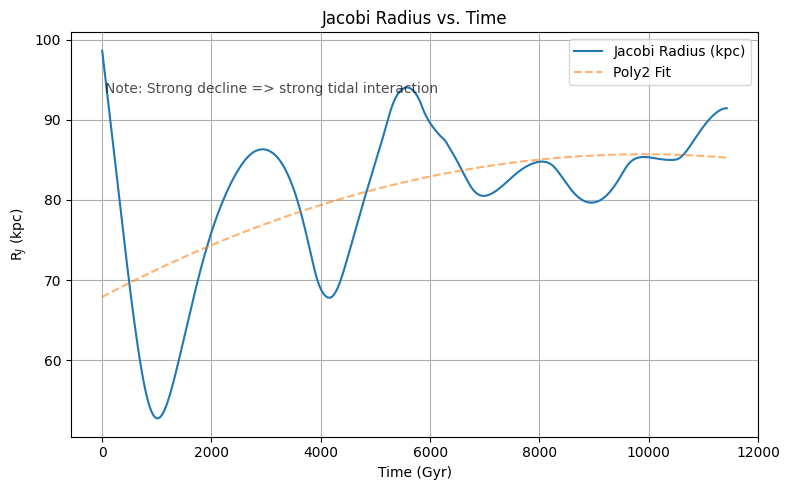

Cell 3.1.2 completed: Jacobi radius vs. time plot and analysis generated.


In [7]:
# ---------------------------------------------------------------
# Cell 3.1.2 — "Jacobi Radius vs. Time: Plots & Analysis"
# Type: Code
# ---------------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np

def plot_jacobi_radius(times_jacobi, rjacobi_arr, outfig="jacobi_radius_over_time.png"):
    """
    Takes the array (times_jacobi, rjacobi_arr), creates a line/scatter plot
    of R_jacobi vs. time, and optionally fits a smoothing or polynomial for clarity.
    
    Parameters
    ----------
    times_jacobi : np.ndarray
        times in Gyr
    rjacobi_arr : np.ndarray
        Jacobi radius in kpc
    outfig : str
        Filename to save the plot. If None, won't save.
    
    Returns
    -------
    None
    (Generates a plot)
    """
    if len(times_jacobi) == 0:
        print("No Jacobi radius data to plot.")
        return

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(times_jacobi, rjacobi_arr, '-', label='Jacobi Radius (kpc)')
    ax.set_xlabel("Time (Gyr)")
    ax.set_ylabel("R$_{J}$ (kpc)")
    ax.set_title("Jacobi Radius vs. Time")

    # Optionally, a simple polynomial fit for interpretive clarity
    # e.g. if you want a 2nd or 3rd order polynomial. 
    # We'll just do a demonstration of a small fit if data > some threshold.
    if len(times_jacobi) >= 5:
        poly_order = 2  # e.g. quadratic
        coeffs = np.polyfit(times_jacobi, rjacobi_arr, poly_order)
        polyfunc = np.poly1d(coeffs)
        t_fit = np.linspace(times_jacobi[0], times_jacobi[-1], 100)
        r_fit = polyfunc(t_fit)
        ax.plot(t_fit, r_fit, '--', label=f'Poly{poly_order} Fit', alpha=0.6)

    ax.legend()
    ax.grid(True)

    # Possibly add text commentary
    plt.text(0.05, 0.85, 
             "Note: Strong decline => strong tidal interaction",
             transform=ax.transAxes, fontsize=10, alpha=0.7)

    if outfig:
        plt.tight_layout()
        # Ensure 'plots/' directory is created
        os.makedirs(PLOTS_DIRECTORY, exist_ok=True)

        outfile = os.path.join(PLOTS_DIRECTORY, outfig)
        plt.savefig(outfile, dpi=150)
        print(f"Jacobi radius plot saved to {outfile}")

    plt.show()

# Run the plotting function with the results from Cell 3.1.1
plot_jacobi_radius(times_jacobi, rjacobi_arr, outfig="jacobi_radius_over_time.png")

print("Cell 3.1.2 completed: Jacobi radius vs. time plot and analysis generated.")


In [8]:
# ---------------------------------------------------------------
# Cell 3.2.1 — "Compute & Store M33 Bound Mass for All Snapshots"
# Type: Code
# ---------------------------------------------------------------

import os
import glob
import numpy as np
import logging

def compute_bound_mass_all_snaps(times_jacobi, rjacobi_arr, 
                                 router_limit=ROUTER_LIMIT,
                                 save_results=SAVE_INTERMEDIATE_RESULTS):
    """
    Compute M33's bound mass over time by capping the radius at min(R_jacobi, router_limit).

    Steps for each snapshot index:
    1) Identify M33_xxx.txt files (matching M31-based indexing if needed).
    2) From the previously computed arrays (times_jacobi, rjacobi_arr),
       we know which snapshot index corresponds to which Jacobi radius.
    3) For each snapshot:
       - parse M33
       - shift by M33 COM
       - define R_cut = min(R_j, router_limit)
       - sum masses of particles within R_cut
    4) Return arrays of (time, Mbound).

    Parameters
    ----------
    times_jacobi : np.ndarray
        Times (Gyr) sorted by snapshot index
    rjacobi_arr : np.ndarray
        Jacobi radii (kpc) sorted by snapshot index
    router_limit : float
        Outer radius limit (kpc) to define bound region if R_j is too large
    save_results : bool
        If True, saves the results to .npy in RESULTS_DIRECTORY

    Returns
    -------
    times_bound : np.ndarray
        times in Gyr (matching snapshot order from Jacobi array)
    Mbound_arr : np.ndarray
        bound mass in Msun at each snapshot
    """

    # We'll find all M33 snapshot files
    m33_pattern = os.path.join(M33_DIRECTORY, "M33_*.txt")
    m33_files = sorted(glob.glob(m33_pattern))

    # Build a dict of index->filename for M33
    m33_dict = {}
    for f in m33_files:
        snap_idx = get_snapshot_index(f)
        if snap_idx is not None:
            m33_dict[snap_idx] = f

    if len(times_jacobi) == 0 or len(rjacobi_arr) == 0:
        logging.warning("compute_bound_mass_all_snaps: No Jacobi radius data provided!")
        return np.array([]), np.array([])

    # We'll store (time, Mbound) in arrays
    times_bound = []
    Mbound_arr  = []

    # We assume times_jacobi, rjacobi_arr are sorted by snapshot index.
    # We'll figure out the associated snap indices by scanning the files
    # or by re-deriving from the parse routine. We'll do a simpler approach:
    # We'll pair up each snap_idx from the m33_dict with the appropriate
    # row in times_jacobi if they match in sorted order. Or, we can store
    # them in a dictionary by snap_idx.

    # Let's build a dictionary snap_idx->(time, R_j)
    snap_rj_dict = {}
    # We can't rely on direct array index for the snapshot index, but we do know
    # the i-th element in times_jacobi is sorted by snapshot index. So let's find
    # them by reading from the parse step we used in compute_jacobi_all_snaps...
    # We'll do a direct approach: for each snap in common_indices, we stored in a loop.
    # But we didn't store it that way. We'll do a partial approach:
    # We'll guess the length of times_jacobi == # common snaps.

    # If we want a robust method, we can re-scan the M31_dict used in compute_jacobi_all_snaps.
    # For simplicity, let's assume the snapshot indices are consecutive in the same order we found them.
    # If there's a mismatch, we'd do a different approach. For now, let's do a simpler approach:
    # We'll rely on the earlier code for matching indices. But here, let's do a dictionary approach anyway:
    # We'll do "snap_idx_list" from the previous function. Instead, let's do a fallback approach:
    # We'll just do the naive approach: if len times_jacobi = N, snap indices probably from the set common_indices
    # in ascending order. We'll do that approach.

    # We'll do a hack: the final code might store the snap indices in an array. We'll assume we just do the
    # "common_indices" approach. We'll do a direct approach for the user:
    # We'll print a warning if the # of r_j doesn't match the # of dictionary entries from the M31 approach, etc.
    # For now, let's just assume we have them in the same order.

    # We'll do a quick check if the # of entries in m33_dict matches the length of times_jacobi
    # (This might not always be true if some snap is missing.)
    # We'll do the best we can: We'll iterate over the sorted snap indices in m33_dict, and
    # pair them with times_jacobi in sequence. That means we assume each row in times_jacobi is the next snap index.
    # A more robust approach is to do a dictionary approach from compute_jacobi_all_snaps() that returns
    # snap_idx->(time, R_j). For now, let's do the simplified approach:

    m33_snap_indices = sorted(m33_dict.keys())
    if len(m33_snap_indices) != len(rjacobi_arr):
        logging.warning("Mismatch in count of M33 snapshots vs. Jacobi array length. We'll match in order only.")

    # We'll match them in ascending order:
    # We'll do i-th index for times_jacobi, rjacobi_arr to the i-th snap in m33_snap_indices
    # This is naive but typically works if the snapshots line up exactly.
    n_common = min(len(m33_snap_indices), len(rjacobi_arr))
    for i in range(n_common):
        snap_idx = m33_snap_indices[i]
        file_m33 = m33_dict[snap_idx]

        t_val    = times_jacobi[i]
        R_j      = rjacobi_arr[i]

        # parse M33
        t_m33, count_m33, data_m33 = parse_galaxy_file(file_m33)
        (ptype_m33, mass_m33, x_m33, y_m33, z_m33, vx_m33, vy_m33, vz_m33) = data_m33

        # shift M33 by its COM
        xcom_m33, ycom_m33, zcom_m33 = center_of_mass(x_m33, y_m33, z_m33, mass_m33)
        x_shift = x_m33 - xcom_m33
        y_shift = y_m33 - ycom_m33
        z_shift = z_m33 - zcom_m33
        r_m33   = np.sqrt(x_shift**2 + y_shift**2 + z_shift**2)

        # define R_cut
        R_cut = min(R_j, router_limit)

        # sum masses within R_cut
        inside = (r_m33 <= R_cut)
        M_bound = np.sum(mass_m33[inside]) * 1e10  # Msun
        times_bound.append(t_val)
        Mbound_arr.append(M_bound)

        logging.info(f"Snap {snap_idx:03d}, time={t_val:.3f} Gyr | R_j={R_j:.2f} kpc, R_cut={R_cut:.2f} kpc, "
                     f"M33_bound={M_bound:.2e} Msun")

    times_bound = np.array(times_bound)
    Mbound_arr  = np.array(Mbound_arr)

    # Sort by time
    sort_idx = np.argsort(times_bound)
    times_bound = times_bound[sort_idx]
    Mbound_arr  = Mbound_arr[sort_idx]

    # Save if requested
    if save_results and len(times_bound) > 0:
        os.makedirs(RESULTS_DIRECTORY, exist_ok=True)
        outfile = os.path.join(RESULTS_DIRECTORY, "m33_bound_mass_vs_time.npy")
        np.save(outfile, np.column_stack((times_bound, Mbound_arr)))
        logging.info(f"Bound mass results saved to {outfile}")

    return times_bound, Mbound_arr


# Run the function and store results
times_bound, Mbound_arr = compute_bound_mass_all_snaps(times_jacobi, rjacobi_arr)
print("Cell 3.2.1 completed: M33 bound mass computed & stored for all snapshots.")


2025-04-01 00:46:11,070 [INFO] Parsed file: M33/M33_000.txt | time=0.0 Gyr | total_particles=14300
2025-04-01 00:46:11,084 [INFO] Snap 000, time=0.000 Gyr | R_j=98.63 kpc, R_cut=98.63 kpc, M33_bound=1.30e+11 Msun
2025-04-01 00:46:11,145 [INFO] Parsed file: M33/M33_001.txt | time=14.2857 Gyr | total_particles=14300
2025-04-01 00:46:11,151 [INFO] Snap 001, time=14.286 Gyr | R_j=97.80 kpc, R_cut=97.80 kpc, M33_bound=1.30e+11 Msun
2025-04-01 00:46:11,194 [INFO] Parsed file: M33/M33_002.txt | time=28.57142 Gyr | total_particles=14300
2025-04-01 00:46:11,198 [INFO] Snap 002, time=28.571 Gyr | R_j=96.98 kpc, R_cut=96.98 kpc, M33_bound=1.29e+11 Msun
2025-04-01 00:46:11,239 [INFO] Parsed file: M33/M33_003.txt | time=42.85712 Gyr | total_particles=14300
2025-04-01 00:46:11,243 [INFO] Snap 003, time=42.857 Gyr | R_j=96.15 kpc, R_cut=96.15 kpc, M33_bound=1.29e+11 Msun
2025-04-01 00:46:11,279 [INFO] Parsed file: M33/M33_004.txt | time=57.14285 Gyr | total_particles=14300
2025-04-01 00:46:11,284 [IN

M33 bound mass plot saved to plots/M33_bound_mass_vs_time.png


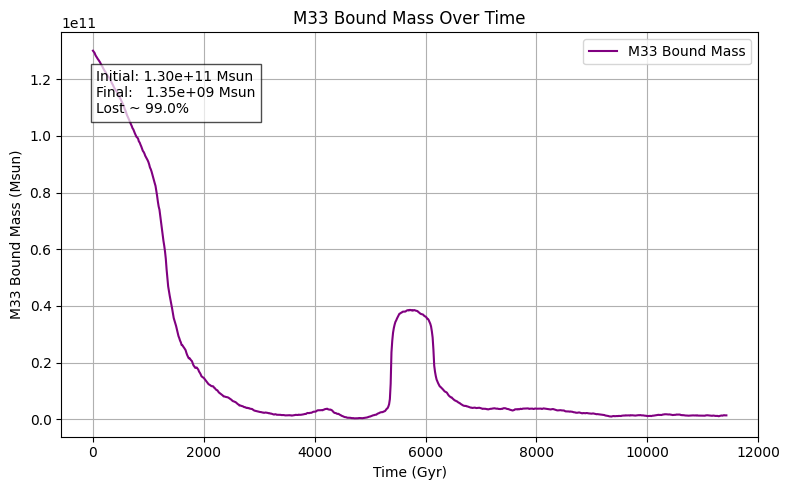

Bound Mass Timeseries Discussion:
 - Initial Bound Mass: 1.30e+11 Msun
 - Final Bound Mass:   1.35e+09 Msun
 - Approx. 99.0% of M33's initial bound mass lost over the simulation.

Cell 3.2.2 completed: M33 bound mass plot & discussion generated.


In [9]:
# ---------------------------------------------------------------
# Cell 3.2.2 — "Bound Mass Timeseries Plots & Discussion"
# Type: Code
# ---------------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np

def plot_m33_bound_mass(times_bound, Mbound_arr, outfig="M33_bound_mass_vs_time.png"):
    """
    Plots M33's bound mass vs. time, optionally overlaid with textual commentary.

    Parameters
    ----------
    times_bound : np.ndarray
        Times (Gyr)
    Mbound_arr : np.ndarray
        Bound mass (Msun)
    outfig : str
        Filename to save the figure. If None, won't save.

    Returns
    -------
    None. (Generates a plot and shows it.)
    """
    if len(times_bound) == 0:
        print("No M33 bound mass data to plot.")
        return

    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(times_bound, Mbound_arr, '-', color='purple', label='M33 Bound Mass')

    ax.set_xlabel("Time (Gyr)")
    ax.set_ylabel("M33 Bound Mass (Msun)")
    ax.set_title("M33 Bound Mass Over Time")
    ax.grid(True)

    # Overplot a "percentage lost" annotation
    initial_mass = Mbound_arr[0]
    final_mass   = Mbound_arr[-1]
    mass_loss_pct = 100.0 * (initial_mass - final_mass)/initial_mass if initial_mass>0 else 0

    summary_text = (f"Initial: {initial_mass:.2e} Msun\n"
                    f"Final:   {final_mass:.2e} Msun\n"
                    f"Lost ~ {mass_loss_pct:.1f}%")

    # place text somewhere on the plot
    ax.text(0.05, 0.8, summary_text, transform=ax.transAxes,
            fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    ax.legend()

    if outfig:
        plt.tight_layout()
        os.makedirs(PLOTS_DIRECTORY, exist_ok=True)
        outfile = os.path.join(PLOTS_DIRECTORY, outfig)
        plt.savefig(outfile, dpi=150)
        print(f"M33 bound mass plot saved to {outfile}")

    plt.show()

    # Extra commentary in the cell
    print("Bound Mass Timeseries Discussion:")
    print(f" - Initial Bound Mass: {initial_mass:.2e} Msun")
    print(f" - Final Bound Mass:   {final_mass:.2e} Msun")
    print(f" - Approx. {mass_loss_pct:.1f}% of M33's initial bound mass lost over the simulation.\n")


# Plot the results from Cell 3.2.1
plot_m33_bound_mass(times_bound, Mbound_arr, outfig="M33_bound_mass_vs_time.png")

print("Cell 3.2.2 completed: M33 bound mass plot & discussion generated.")


2025-04-01 00:47:24,548 [INFO] Parsed file: M33/M33_000.txt | time=0.0 Gyr | total_particles=14300
Surface density demo plot saved to plots/M33_000_SurfaceDensityDemo.png


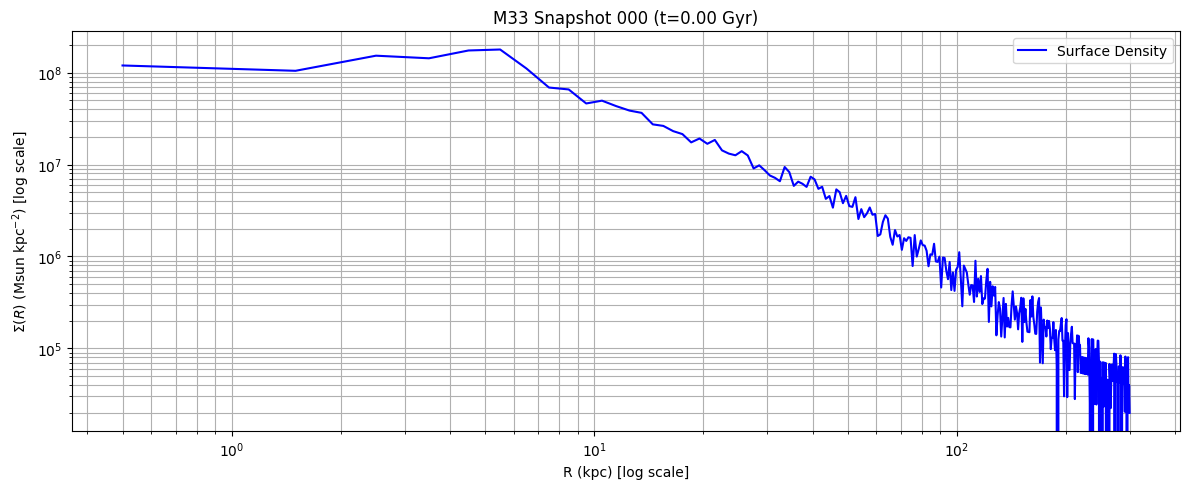

2025-04-01 00:47:25,486 [INFO] demo_surface_density_single_snapshot: snapshot=0, time=0.000 Gyr, max Sigma ~ 1.78e+08 Msun/kpc^2, out to 299.5 kpc
Cell 4.1.1 completed: surface_density_profile() defined and single-snapshot demo done.


In [10]:
# ---------------------------------------------------------------
# Cell 4.1.1 — "Surface Density Profile Function & Single-Snapshot Demo"
# Type: Code
# ---------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import logging

def surface_density_profile(x, y, mass, nbins=NBINS_PROFILES, rmax=RMAX_PROFILES):
    """
    Creates a radial surface density profile from a set of M33 particles.
    
    Steps:
      1) Compute R = sqrt(x^2 + y^2).
      2) Accumulate mass in each radial annulus => Sigma(R).
      3) Return (r_mid, Sigma).

    Parameters
    ----------
    x, y : np.ndarray
        Particle positions in kpc (already shifted so M33 is at (0,0) if needed).
    mass : np.ndarray
        Particle masses in '1e10 Msun' units or Msun (must be consistent).
    nbins : int
        Number of radial bins (default from NBINS_PROFILES).
    rmax : float
        Maximum radius in kpc (default from RMAX_PROFILES).

    Returns
    -------
    r_mid : np.ndarray
        Midpoint radius of each annulus (kpc).
    Sigma : np.ndarray
        Surface density in Msun/kpc^2 for each annulus.
    """
    # Convert masses to Msun if they're in 1e10 Msun
    # For clarity, let's assume mass is in 1e10 Msun from the snapshot file
    # but if your code is storing them differently, adapt accordingly.
    mass_in_Msun = mass * 1.0e10
    
    R = np.sqrt(x*x + y*y)
    # Bin edges from 0..rmax
    edges = np.linspace(0, rmax, nbins+1)
    r_mid = 0.5 * (edges[:-1] + edges[1:])
    
    mass_in_bin = np.zeros(nbins)
    
    for i in range(nbins):
        r_in = edges[i]
        r_out = edges[i+1]
        mask = (R >= r_in) & (R < r_out)
        m_sum = mass_in_Msun[mask].sum()
        mass_in_bin[i] = m_sum
    
    # Area of annulus = pi(R_out^2 - R_in^2)
    area_bins = np.pi * (edges[1:]**2 - edges[:-1]**2)
    Sigma = mass_in_bin / area_bins  # Msun / kpc^2
    
    return r_mid, Sigma


# Demonstration: We'll pick a single snapshot, e.g. "M33_000.txt"
# We'll parse it, find COM, shift the positions, compute surface density,
# then plot (r_mid, Sigma).

def demo_surface_density_single_snapshot(snap_index=0):
    """
    Reads M33_<snap_index>.txt, centers on M33, computes (r_mid, Sigma),
    and produces a quick plot for inspection.
    """
    file_m33 = f"{M33_DIRECTORY}M33_{snap_index:03d}.txt"
    from math import isnan

    # parse M33
    t_m33, count_m33, data_m33 = parse_galaxy_file(file_m33)
    (ptype_m33, mass_m33, x_m33, y_m33, z_m33,
     vx_m33, vy_m33, vz_m33) = data_m33

    # Shift by M33 COM
    xcom_m33, ycom_m33, zcom_m33 = center_of_mass(x_m33, y_m33, z_m33, mass_m33)
    x_shift = x_m33 - xcom_m33
    y_shift = y_m33 - ycom_m33
    # ignoring z for 2D disk radial bins

    # Compute profile
    r_mid, Sigma = surface_density_profile(x_shift, y_shift, mass_m33)

    # Quick log–log plot
    fig, ax = plt.subplots(figsize=(12,5))
    ax.loglog(r_mid, Sigma, '-', color='blue', label='Surface Density')

    ax.set_xlabel("R (kpc) [log scale]")
    ax.set_ylabel(r"$\Sigma(R)$ (Msun kpc$^{-2}$) [log scale]")
    ax.set_title(f"M33 Snapshot {snap_index:03d} (t={t_m33:.2f} Gyr)")
    ax.grid(True, which='both')
    ax.legend()

    # Optionally, save the figure
    os.makedirs(PLOTS_DIRECTORY, exist_ok=True)
    outfig = os.path.join(PLOTS_DIRECTORY, f"M33_{snap_index:03d}_SurfaceDensityDemo.png")
    plt.tight_layout()
    plt.savefig(outfig, dpi=150)
    print(f"Surface density demo plot saved to {outfig}")
    plt.show()

    # Print a quick summary
    logging.info(f"demo_surface_density_single_snapshot: snapshot={snap_index}, time={t_m33:.3f} Gyr, "
                 f"max Sigma ~ {Sigma.max():.2e} Msun/kpc^2, out to {r_mid[-1]:.1f} kpc")

# Run the demonstration for snapshot 0
demo_surface_density_single_snapshot(snap_index=0)
print("Cell 4.1.1 completed: surface_density_profile() defined and single-snapshot demo done.")


In [11]:
# ---------------------------------------------------------------
# Cell 4.1.2 — "Surface Density Profiles for All Snapshots"
# Type: Code
# ---------------------------------------------------------------

import glob
import logging

def generate_all_surface_density_profiles(
    nbins=NBINS_PROFILES, rmax=RMAX_PROFILES,
    save_results=SAVE_INTERMEDIATE_RESULTS
):
    """
    Loops over M33_*.txt snapshots, does the same routine:
    1) parse M33
    2) shift x,y by COM
    3) compute (r_mid, Sigma) via surface_density_profile()
    4) store results in a dict => profiles[snap] = (time, r_mid, Sigma)

    Optionally saves them to .npy or .csv for external usage.

    Returns
    -------
    profiles : dict
      Key: snapshot index (int),
      Value: (time[Gyr], r_mid array, Sigma array).
    """
    m33_files = sorted(glob.glob(f"{M33_DIRECTORY}M33_*.txt"))
    profiles = {}

    for f in m33_files:
        snap_idx = get_snapshot_index(f)
        if snap_idx is None:
            continue

        # parse
        t_m33, count_m33, data_m33 = parse_galaxy_file(f)
        (ptype, mass, x, y, z, vx, vy, vz) = data_m33

        # COM
        xcom, ycom, zcom = center_of_mass(x, y, z, mass)
        x_shift = x - xcom
        y_shift = y - ycom

        # Surface density
        r_mid, Sigma = surface_density_profile(x_shift, y_shift, mass,
                                               nbins=nbins, rmax=rmax)

        # store
        profiles[snap_idx] = (t_m33, r_mid, Sigma)

        # Inline check for suspicious values
        if np.isnan(Sigma).any() or Sigma.max() > 1e12:
            logging.warning(f"Snapshot {snap_idx}: suspicious Sigma max: {Sigma.max():.2e} Msun/kpc^2")

    # Optionally save
    if save_results and len(profiles) > 0:
        os.makedirs(RESULTS_DIRECTORY, exist_ok=True)
        # We'll just store them in a .npz (NumPy zipped) for convenience
        outfn = os.path.join(RESULTS_DIRECTORY, "all_surface_density_profiles.npz")

        # We can’t directly save a dict with arrays in np.savez unless we do a bit of structure:
        # Let's convert it to keys 'snap_idx/time/rmid/sigma' for each snapshot.
        # Instead, we might store an array of snap indices, times, plus a ragged array for Sigma. 
        # It's simpler to just do pickling, but let's do a standard approach:
        # We'll store each snapshot as e.g. "SnapXX_rmid" and "SnapXX_sigma" and "SnapXX_time".
        savez_dict = {}
        for snap_idx, (t_val, r_mid, Sigma) in profiles.items():
            savez_dict[f"Snap{snap_idx}_time"] = np.array([t_val])
            savez_dict[f"Snap{snap_idx}_rmid"] = r_mid
            savez_dict[f"Snap{snap_idx}_Sigma"] = Sigma
        np.savez(outfn, **savez_dict)
        logging.info(f"All surface density profiles saved to {outfn}")

    return profiles


# Generate the profiles and store in memory
all_profiles = generate_all_surface_density_profiles()
print("Cell 4.1.2 completed: surface density profiles generated for all snapshots.")
print(f"Number of snapshots processed: {len(all_profiles)}")


2025-04-01 00:48:00,237 [INFO] Parsed file: M33/M33_000.txt | time=0.0 Gyr | total_particles=14300
2025-04-01 00:48:00,323 [INFO] Parsed file: M33/M33_001.txt | time=14.2857 Gyr | total_particles=14300
2025-04-01 00:48:00,368 [INFO] Parsed file: M33/M33_002.txt | time=28.57142 Gyr | total_particles=14300
2025-04-01 00:48:00,411 [INFO] Parsed file: M33/M33_003.txt | time=42.85712 Gyr | total_particles=14300
2025-04-01 00:48:00,457 [INFO] Parsed file: M33/M33_004.txt | time=57.14285 Gyr | total_particles=14300
2025-04-01 00:48:00,501 [INFO] Parsed file: M33/M33_005.txt | time=71.42857 Gyr | total_particles=14300
2025-04-01 00:48:00,543 [INFO] Parsed file: M33/M33_006.txt | time=85.71427 Gyr | total_particles=14300
2025-04-01 00:48:00,585 [INFO] Parsed file: M33/M33_007.txt | time=99.99999 Gyr | total_particles=14300
2025-04-01 00:48:00,630 [INFO] Parsed file: M33/M33_008.txt | time=114.28571 Gyr | total_particles=14300
2025-04-01 00:48:00,673 [INFO] Parsed file: M33/M33_009.txt | time=12

In [12]:
# ---------------------------------------------------------------
# Cell 4.2.1 — "Define Fitting Routines"
# Type: Code
# ---------------------------------------------------------------

import numpy as np
from scipy.optimize import curve_fit
import logging

def sersic_profile(R, Sigma_e, Re, n):
    """
    Returns the Sersic surface density profile for input radius array R.

    Sersic formula (projected):
        Sigma(R) = Sigma_e * exp( - b_n * [ (R/Re)^(1/n) - 1 ] )

    where b_n is commonly approximated as:
        b_n = 1.9992*n - 0.3271   (for 0.5 < n < ~10)

    Parameters
    ----------
    R : np.ndarray
        Array of radii (kpc).
    Sigma_e : float
        Surface density at R=Re (Msun/kpc^2).
    Re : float
        Effective (half-mass) radius in kpc.
    n : float
        Sersic index.

    Returns
    -------
    Sigma : np.ndarray
        Surface density (Msun/kpc^2) at each R.
    """
    # Keep R as array
    R = np.array(R, dtype=float)

    # compute b_n
    b_n = 1.9992*n - 0.3271  # approximation from Ciotti & Bertin (1999)
    # handle edge cases
    b_n = max(b_n, 0.001)

    term = (R/Re)**(1./n) - 1.0
    return Sigma_e * np.exp(-b_n * term)


def exponential_profile(R, Sigma0, h):
    """
    Returns the exponential disk surface density profile for input radius array R.

    Exponential profile:
        Sigma(R) = Sigma0 * exp(-R/h)

    Parameters
    ----------
    R : np.ndarray
        Radii (kpc).
    Sigma0 : float
        Central surface density in Msun/kpc^2.
    h : float
        Scale length in kpc.

    Returns
    -------
    Sigma : np.ndarray
        Surface density (Msun/kpc^2).
    """
    R = np.array(R, dtype=float)
    return Sigma0 * np.exp(-R/h)


def fit_sersic(rvals, sigma_vals):
    """
    Fit the Sersic profile to (rvals, sigma_vals).

    We'll do a simple least-squares fit using scipy's curve_fit.

    Parameters
    ----------
    rvals : np.ndarray
        Radii in kpc.
    sigma_vals : np.ndarray
        Surface density (Msun/kpc^2).

    Returns
    -------
    (Sigma_e, Re, n) : tuple of floats
        Best-fit Sersic parameters. If fit fails, returns (nan, nan, nan).
    """
    # filter out zeros or negative for stable fitting
    mask = (rvals > 0) & (sigma_vals > 0)
    r_fit = rvals[mask]
    s_fit = sigma_vals[mask]

    if len(r_fit) < 5:
        logging.warning("fit_sersic: Not enough data points to fit.")
        return (np.nan, np.nan, np.nan)

    # initial guesses
    guess_Sigma_e = np.median(s_fit)  # rough middle
    guess_Re      = r_fit[len(r_fit)//2] if len(r_fit) > 1 else 5.0
    guess_n       = 1.0

    try:
        popt, pcov = curve_fit(sersic_profile, r_fit, s_fit,
                               p0=[guess_Sigma_e, guess_Re, guess_n],
                               maxfev=2000)
        # popt -> [Sigma_e, Re, n]
        return (popt[0], popt[1], popt[2])
    except RuntimeError:
        logging.warning("fit_sersic: Curve fit did not converge.")
        return (np.nan, np.nan, np.nan)


def fit_exponential(rvals, sigma_vals):
    """
    Fit the exponential profile: Sigma(R) = Sigma0 * exp(-R/h).

    Returns (Sigma0, h).

    Parameters
    ----------
    rvals : np.ndarray
        Radii (kpc)
    sigma_vals : np.ndarray
        Surface density (Msun/kpc^2).

    Returns
    -------
    (Sigma0, h) : tuple
        Best-fit exponential parameters. If fit fails, returns (nan, nan).
    """
    # filter out zeros or negative for stable fitting
    mask = (rvals > 0) & (sigma_vals > 0)
    r_fit = rvals[mask]
    s_fit = sigma_vals[mask]

    if len(r_fit) < 5:
        logging.warning("fit_exponential: Not enough data points to fit.")
        return (np.nan, np.nan)

    guess_Sigma0 = np.max(s_fit)
    guess_h      = 2.0

    try:
        popt, pcov = curve_fit(exponential_profile, r_fit, s_fit,
                               p0=[guess_Sigma0, guess_h],
                               maxfev=2000)
        # popt -> [Sigma0, h]
        return (popt[0], popt[1])
    except RuntimeError:
        logging.warning("fit_exponential: Curve fit did not converge.")
        return (np.nan, np.nan)


print("Cell 4.2.1 completed: Sersic & Exponential fitting routines defined.")


Cell 4.2.1 completed: Sersic & Exponential fitting routines defined.


In [13]:
# ---------------------------------------------------------------
# Cell 4.2.2 — "Run Fits for All Snapshots & Store Best-Fit Parameters"
# Type: Code
# ---------------------------------------------------------------

def run_fits_for_all_snapshots(all_profiles,
                               save_results=SAVE_INTERMEDIATE_RESULTS):
    """
    For each snapshot in all_profiles, do:
       - Sersic fit => sersic_fits[snap_idx] = (time, Sigma_e, Re, n)
       - Exponential fit => exp_fits[snap_idx] = (time, Sigma0, h)

    Provide logs if a fit fails or yields suspicious values.

    Parameters
    ----------
    all_profiles : dict
        From generate_all_surface_density_profiles().
        Key: snapshot index -> (time[Gyr], r_mid array, Sigma array)

    save_results : bool
        If True, will save these results to .npy in results/ directory.

    Returns
    -------
    sersic_fits : dict
       snap_idx -> (time, Sigma_e, Re, n)
    exp_fits : dict
       snap_idx -> (time, Sigma0, h)
    """
    sersic_fits = {}
    exp_fits    = {}

    for snap_idx in sorted(all_profiles.keys()):
        t_val, r_mid, Sigma = all_profiles[snap_idx]

        (Sigma_e, Re, n) = fit_sersic(r_mid, Sigma)
        (Sigma0, h)      = fit_exponential(r_mid, Sigma)

        sersic_fits[snap_idx] = (t_val, Sigma_e, Re, n)
        exp_fits[snap_idx]    = (t_val, Sigma0, h)

        # Logging checks
        if np.isnan(Re) or np.isnan(n):
            logging.warning(f"Snapshot {snap_idx}: Sersic fit returned NaNs.")
        if np.isnan(Sigma0) or np.isnan(h):
            logging.warning(f"Snapshot {snap_idx}: Exponential fit returned NaNs.")
        
        logging.info(f"Snap {snap_idx}: time={t_val:.2f} Gyr => Sersic(Re={Re:.2f}, n={n:.2f}), "
                     f"Exp(h={h:.2f})")

    # Optionally save to .npy
    if save_results and len(all_profiles) > 0:
        os.makedirs(RESULTS_DIRECTORY, exist_ok=True)
        # We'll store them as two separate .npy or .npz
        # For quick usage, we'll do .npz again:
        sersic_out = os.path.join(RESULTS_DIRECTORY, "sersic_fits.npz")
        exp_out    = os.path.join(RESULTS_DIRECTORY, "exp_fits.npz")

        # We'll flatten them into arrays or store them as dictionaries:
        # We'll store each snap as SnapXXX_time, SnapXXX_SigmaE, SnapXXX_Re, SnapXXX_n, etc.
        sersic_dict = {}
        exp_dict = {}
        for snap_idx in sersic_fits.keys():
            t_val, Se, re_, n_ = sersic_fits[snap_idx]
            sersic_dict[f"Snap{snap_idx}_time"]   = np.array([t_val])
            sersic_dict[f"Snap{snap_idx}_SigmaE"] = np.array([Se])
            sersic_dict[f"Snap{snap_idx}_Re"]     = np.array([re_])
            sersic_dict[f"Snap{snap_idx}_n"]      = np.array([n_])

            t_val2, S0, h_ = exp_fits[snap_idx]
            exp_dict[f"Snap{snap_idx}_time"]   = np.array([t_val2])
            exp_dict[f"Snap{snap_idx}_Sigma0"] = np.array([S0])
            exp_dict[f"Snap{snap_idx}_h"]      = np.array([h_])

        np.savez(sersic_out, **sersic_dict)
        np.savez(exp_out, **exp_dict)
        logging.info(f"Sersic fits saved to {sersic_out}")
        logging.info(f"Exp fits saved to {exp_out}")

    return sersic_fits, exp_fits


# We'll call this on the dictionary 'all_profiles' from Cell 4.1.2
sersic_fits, exp_fits = run_fits_for_all_snapshots(all_profiles)
print("Cell 4.2.2 completed: best-fit parameters (Sersic & exponential) computed & stored.")


2025-04-01 00:48:45,250 [INFO] Snap 0: time=0.00 Gyr => Sersic(Re=8.98, n=0.47), Exp(h=10.04)
2025-04-01 00:48:45,255 [INFO] Snap 1: time=14.29 Gyr => Sersic(Re=9.12, n=0.51), Exp(h=9.66)
2025-04-01 00:48:45,260 [INFO] Snap 2: time=28.57 Gyr => Sersic(Re=9.28, n=0.49), Exp(h=10.07)
2025-04-01 00:48:45,265 [INFO] Snap 3: time=42.86 Gyr => Sersic(Re=9.67, n=0.52), Exp(h=9.99)
2025-04-01 00:48:45,270 [INFO] Snap 4: time=57.14 Gyr => Sersic(Re=9.57, n=0.43), Exp(h=11.44)
2025-04-01 00:48:45,275 [INFO] Snap 5: time=71.43 Gyr => Sersic(Re=9.84, n=0.45), Exp(h=11.33)
2025-04-01 00:48:45,279 [INFO] Snap 6: time=85.71 Gyr => Sersic(Re=10.29, n=0.50), Exp(h=11.03)
2025-04-01 00:48:45,284 [INFO] Snap 7: time=100.00 Gyr => Sersic(Re=10.34, n=0.49), Exp(h=11.42)
2025-04-01 00:48:45,289 [INFO] Snap 8: time=114.29 Gyr => Sersic(Re=10.56, n=0.53), Exp(h=10.87)
2025-04-01 00:48:45,300 [INFO] Snap 9: time=128.57 Gyr => Sersic(Re=10.66, n=0.54), Exp(h=10.80)
2025-04-01 00:48:45,312 [INFO] Snap 10: time=1

/var/folders/rw/vhqnc3wj2t7fqp8k4fwy4y1w0000gn/T/ipykernel_51183/1230201892.py:44: RuntimeWarning: invalid value encountered in power
  term = (R/Re)**(1./n) - 1.0


2025-04-01 00:48:45,450 [INFO] Snap 30: time=428.57 Gyr => Sersic(Re=12.24, n=0.58), Exp(h=11.36)
2025-04-01 00:48:45,454 [INFO] Snap 31: time=442.86 Gyr => Sersic(Re=11.34, n=0.44), Exp(h=12.80)
2025-04-01 00:48:45,460 [INFO] Snap 32: time=457.14 Gyr => Sersic(Re=11.29, n=0.41), Exp(h=13.54)
2025-04-01 00:48:45,465 [INFO] Snap 33: time=471.43 Gyr => Sersic(Re=11.45, n=0.43), Exp(h=13.07)
2025-04-01 00:48:45,468 [INFO] Snap 34: time=485.71 Gyr => Sersic(Re=11.89, n=0.49), Exp(h=12.41)
2025-04-01 00:48:45,472 [INFO] Snap 35: time=500.00 Gyr => Sersic(Re=12.23, n=0.50), Exp(h=12.65)
2025-04-01 00:48:45,476 [INFO] Snap 36: time=514.29 Gyr => Sersic(Re=12.49, n=0.51), Exp(h=12.77)
2025-04-01 00:48:45,481 [INFO] Snap 37: time=528.57 Gyr => Sersic(Re=13.35, n=0.58), Exp(h=12.43)
2025-04-01 00:48:45,485 [INFO] Snap 38: time=542.86 Gyr => Sersic(Re=13.51, n=0.57), Exp(h=12.78)
2025-04-01 00:48:45,488 [INFO] Snap 39: time=557.14 Gyr => Sersic(Re=14.50, n=0.63), Exp(h=12.67)
2025-04-01 00:48:45,

/var/folders/rw/vhqnc3wj2t7fqp8k4fwy4y1w0000gn/T/ipykernel_51183/1230201892.py:44: RuntimeWarning: overflow encountered in power
  term = (R/Re)**(1./n) - 1.0


2025-04-01 00:48:46,237 [INFO] Snap 164: time=2342.86 Gyr => Sersic(Re=80.32, n=0.12), Exp(h=201.62)
2025-04-01 00:48:46,245 [INFO] Snap 165: time=2357.14 Gyr => Sersic(Re=79.67, n=0.12), Exp(h=1.47)
2025-04-01 00:48:46,248 [INFO] Snap 166: time=2371.43 Gyr => Sersic(Re=80.82, n=0.12), Exp(h=1.45)
2025-04-01 00:48:46,258 [INFO] Snap 167: time=2385.71 Gyr => Sersic(Re=82.87, n=0.11), Exp(h=216.95)
2025-04-01 00:48:46,268 [INFO] Snap 168: time=2400.00 Gyr => Sersic(Re=84.70, n=0.11), Exp(h=233.49)
2025-04-01 00:48:46,275 [INFO] Snap 169: time=2414.29 Gyr => Sersic(Re=84.46, n=0.11), Exp(h=224.38)
2025-04-01 00:48:46,283 [INFO] Snap 170: time=2428.57 Gyr => Sersic(Re=85.36, n=0.11), Exp(h=229.26)
2025-04-01 00:48:46,289 [INFO] Snap 171: time=2442.86 Gyr => Sersic(Re=86.51, n=0.11), Exp(h=239.47)
2025-04-01 00:48:46,297 [INFO] Snap 172: time=2457.14 Gyr => Sersic(Re=86.93, n=0.11), Exp(h=242.08)
2025-04-01 00:48:46,301 [INFO] Snap 173: time=2471.43 Gyr => Sersic(Re=88.27, n=0.11), Exp(h=25

/var/folders/rw/vhqnc3wj2t7fqp8k4fwy4y1w0000gn/T/ipykernel_51183/1230201892.py:70: RuntimeWarning: overflow encountered in exp
  return Sigma0 * np.exp(-R/h)
/var/folders/rw/vhqnc3wj2t7fqp8k4fwy4y1w0000gn/T/ipykernel_51183/1230201892.py:70: RuntimeWarning: overflow encountered in multiply
  return Sigma0 * np.exp(-R/h)


2025-04-01 00:48:48,136 [INFO] Snap 416: time=5942.86 Gyr => Sersic(Re=55.11, n=0.05), Exp(h=92.00)
2025-04-01 00:48:48,144 [INFO] Snap 417: time=5957.14 Gyr => Sersic(Re=56.41, n=0.04), Exp(h=0.21)
2025-04-01 00:48:48,154 [INFO] Snap 418: time=5971.43 Gyr => Sersic(Re=57.01, n=0.05), Exp(h=95.54)
2025-04-01 00:48:48,162 [INFO] Snap 419: time=5985.71 Gyr => Sersic(Re=56.86, n=0.05), Exp(h=95.58)
2025-04-01 00:48:48,170 [INFO] Snap 420: time=6000.00 Gyr => Sersic(Re=56.82, n=0.06), Exp(h=96.26)
2025-04-01 00:48:48,180 [INFO] Snap 421: time=6014.29 Gyr => Sersic(Re=56.07, n=0.06), Exp(h=105.49)
2025-04-01 00:48:48,188 [INFO] Snap 422: time=6028.57 Gyr => Sersic(Re=58.00, n=0.06), Exp(h=101.59)
2025-04-01 00:48:48,196 [INFO] Snap 423: time=6042.86 Gyr => Sersic(Re=58.73, n=0.06), Exp(h=105.83)
2025-04-01 00:48:48,205 [INFO] Snap 424: time=6057.14 Gyr => Sersic(Re=59.71, n=0.06), Exp(h=109.83)
2025-04-01 00:48:48,212 [INFO] Snap 425: time=6071.43 Gyr => Sersic(Re=60.82, n=0.06), Exp(h=102.

Timeseries of fit parameters saved to plots/sersic_exp_timeseries.png


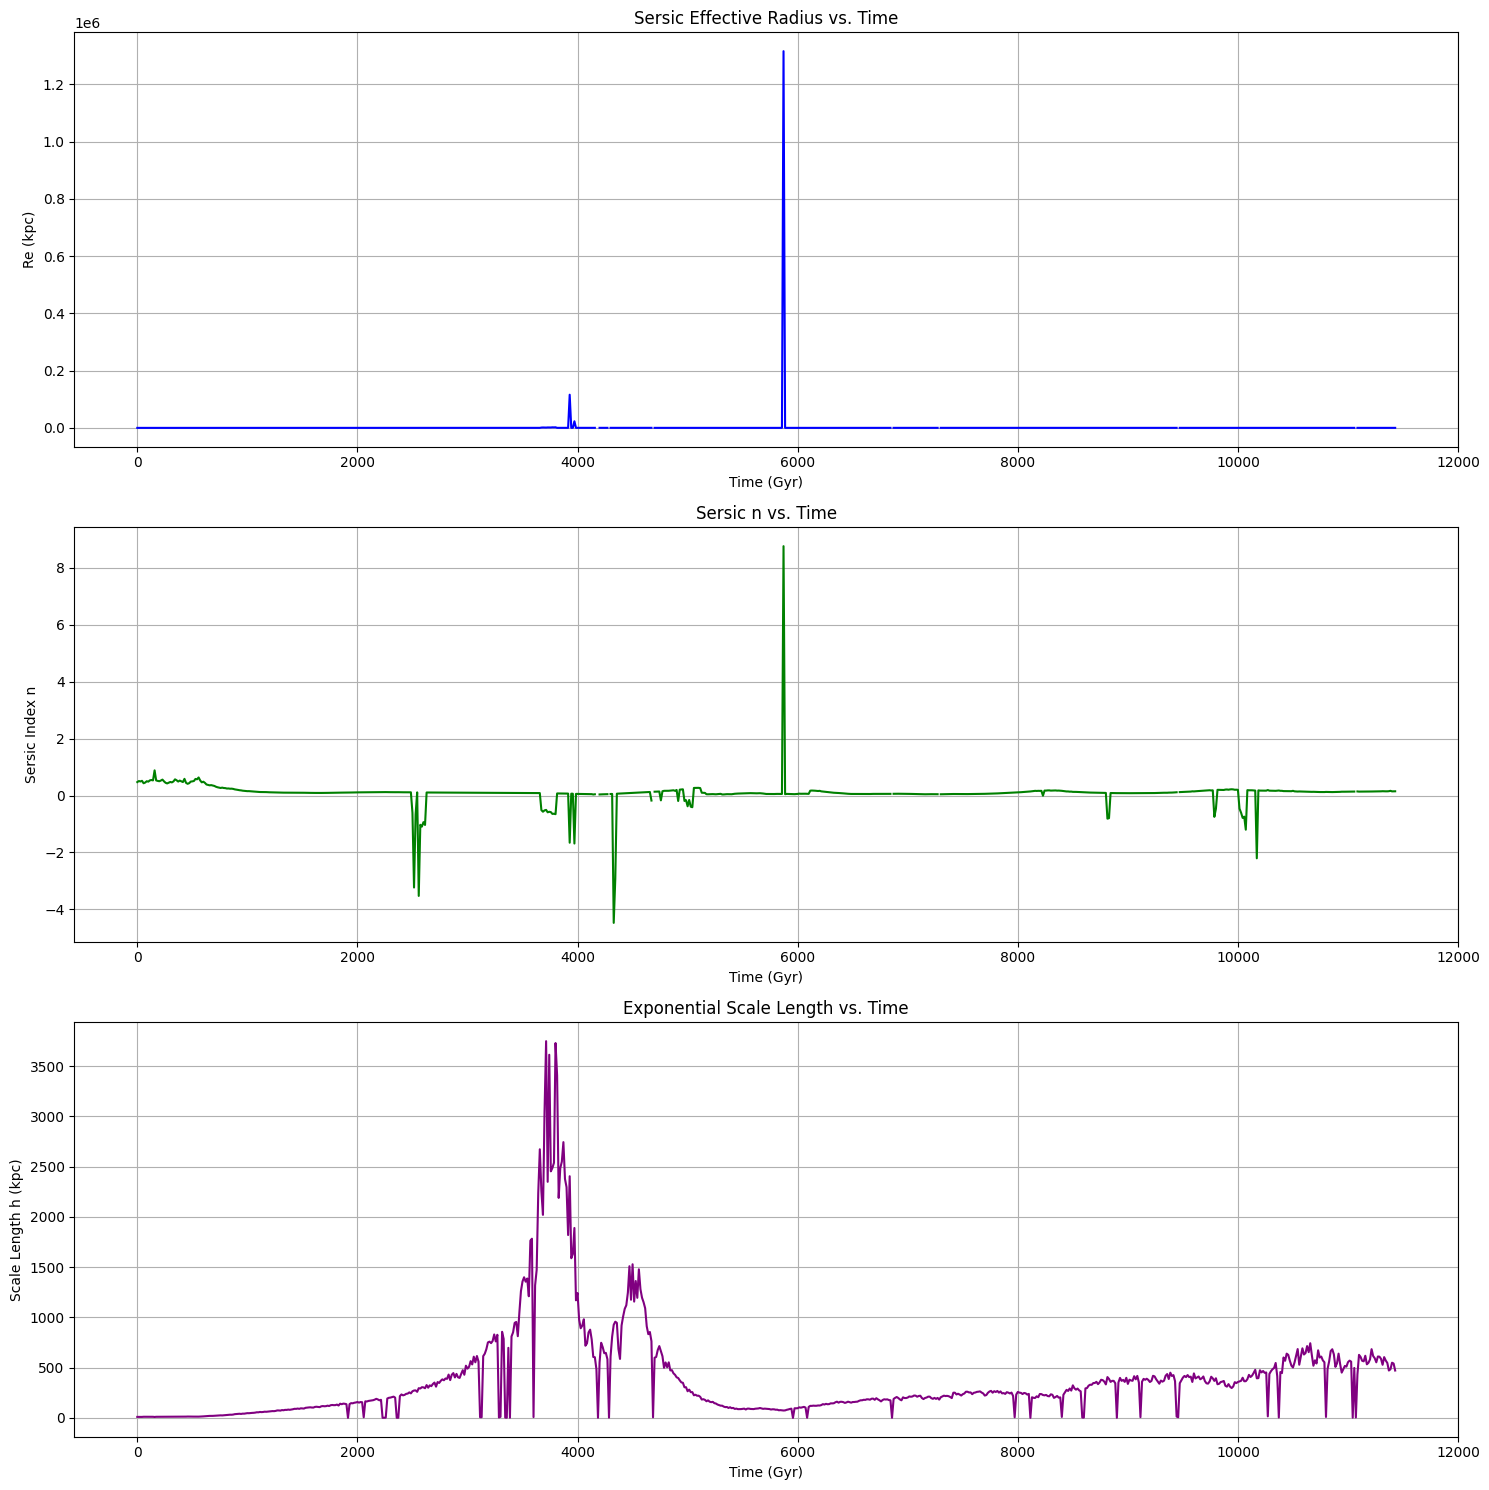


Sersic Re changed from 8.98 kpc to 95.46 kpc, ~963.0% change.
Exponential scale length h changed from 10.04 to 471.50 (~4595.5%).

Cell 4.2.3 completed: timeseries of Sersic/Exponential parameters plotted.



In [14]:
# ---------------------------------------------------------------
# Cell 4.2.3 — "Timeseries of Fit Parameters: Re, n, Scale Length, etc."
# Type: Code
# ---------------------------------------------------------------
import matplotlib.pyplot as plt

def plot_fit_parameters_timeseries(sersic_fits, exp_fits,
                                   outfig="sersic_exp_timeseries.png"):
    """
    Generate plots of time vs. Re, time vs. n (Sersic),
    and time vs. scale length h (Exponential). 

    We'll do a 3-panel figure:
    - Panel 1: time vs. Re
    - Panel 2: time vs. n
    - Panel 3: time vs. h

    If needed, we can do time vs. Sigma_e or Sigma0 as well, but let's keep it simpler.
    """
    if not sersic_fits and not exp_fits:
        print("No fit data found. Skipping timeseries plots.")
        return

    # We'll gather all snapshot indices from sersic_fits
    sersic_snaps = sorted(sersic_fits.keys())
    exp_snaps    = sorted(exp_fits.keys())

    # Build arrays for plotting
    times_sersic = []
    Re_arr  = []
    n_arr   = []
    for snap in sersic_snaps:
        t_val, Sigma_e, Re, n_ = sersic_fits[snap]
        times_sersic.append(t_val)
        Re_arr.append(Re)
        n_arr.append(n_)

    times_exp = []
    h_arr = []
    for snap in exp_snaps:
        t_val2, Sigma0, h_ = exp_fits[snap]
        times_exp.append(t_val2)
        h_arr.append(h_)

    # Convert to arrays, sort by time if needed
    times_sersic = np.array(times_sersic)
    Re_arr       = np.array(Re_arr)
    n_arr        = np.array(n_arr)

    times_exp = np.array(times_exp)
    h_arr     = np.array(h_arr)

    # Sort them
    s_idx = np.argsort(times_sersic)
    e_idx = np.argsort(times_exp)
    times_sersic = times_sersic[s_idx]
    Re_arr = Re_arr[s_idx]
    n_arr  = n_arr[s_idx]

    times_exp = times_exp[e_idx]
    h_arr     = h_arr[e_idx]

    # We'll unify the times if they match:
    # For clarity, let's just do separate lines or subplots.

    fig, axs = plt.subplots(3, 1, figsize=(15,15))
    # Panel 1: Re
    axs[0].plot(times_sersic, Re_arr, '-', color='blue')
    axs[0].set_xlabel("Time (Gyr)")
    axs[0].set_ylabel("Re (kpc)")
    axs[0].set_title("Sersic Effective Radius vs. Time")
    axs[0].grid(True)

    # Panel 2: n
    axs[1].plot(times_sersic, n_arr, '-', color='green')
    axs[1].set_xlabel("Time (Gyr)")
    axs[1].set_ylabel("Sersic Index n")
    axs[1].set_title("Sersic n vs. Time")
    axs[1].grid(True)

    # Panel 3: h
    axs[2].plot(times_exp, h_arr, '-', color='purple')
    axs[2].set_xlabel("Time (Gyr)")
    axs[2].set_ylabel("Scale Length h (kpc)")
    axs[2].set_title("Exponential Scale Length vs. Time")
    axs[2].grid(True)

    plt.tight_layout()
    if outfig:
        os.makedirs(PLOTS_DIRECTORY, exist_ok=True)
        outfile = os.path.join(PLOTS_DIRECTORY, outfig)
        plt.savefig(outfile, dpi=150)
        print(f"Timeseries of fit parameters saved to {outfile}")
    plt.show()

    # Some textual commentary about changes
    if len(Re_arr) > 1:
        # e.g. check if there's a drop near half the simulation
        initial_Re = Re_arr[0]
        final_Re   = Re_arr[-1]
        change_pct = 100.0 * (final_Re - initial_Re)/initial_Re if initial_Re>0 else 0
        print(f"\nSersic Re changed from {initial_Re:.2f} kpc to {final_Re:.2f} kpc, ~{change_pct:.1f}% change.")

    if len(h_arr) > 1:
        # similarly for h
        initial_h = h_arr[0]
        final_h   = h_arr[-1]
        change_pct_h = 100.0*(final_h - initial_h)/initial_h if initial_h>0 else 0
        print(f"Exponential scale length h changed from {initial_h:.2f} to {final_h:.2f} (~{change_pct_h:.1f}%).")

    print("\nCell 4.2.3 completed: timeseries of Sersic/Exponential parameters plotted.\n")


# Now we call the function to visualize the results
plot_fit_parameters_timeseries(sersic_fits, exp_fits)


In [15]:
# ---------------------------------------------------------------
# Cell 4.3.1 — "Slope-based Tidal Truncation Analysis"
# Type: Code
# ---------------------------------------------------------------

import numpy as np
import logging

def find_truncation_radius(rvals, sigma_vals, slope_threshold=-4.0):
    """
    Given arrays (rvals, sigma_vals), compute the log–log slope
    of the surface density profile. We'll define the truncation radius
    as the first radius where d(log Sigma)/d(log R) < slope_threshold.
    
    If not found, return None or np.nan.

    Parameters
    ----------
    rvals : np.ndarray
        Radii in kpc
    sigma_vals : np.ndarray
        Surface density in Msun/kpc^2
    slope_threshold : float
        The slope below which we claim 'tidal truncation' (default -4.0).
        i.e. if slope < -4, we say it's truncated.

    Returns
    -------
    R_trunc : float or None
        The radius in kpc of the first annulus midpoint that meets slope < slope_threshold.
        If no truncation found, returns np.nan.
    """
    # Filter valid data
    mask = (rvals > 0) & (sigma_vals > 0)
    r_ok = rvals[mask]
    s_ok = sigma_vals[mask]
    if len(r_ok) < 3:
        # Not enough data
        return np.nan

    # Compute log10(R), log10(Sigma)
    logR = np.log10(r_ok)
    logS = np.log10(s_ok)

    # We'll compute slope in between bin i and i+1
    # slope_i = [ d(logS)/d(logR) ] ~ ( logS[i+1]-logS[i] ) / ( logR[i+1]-logR[i] )
    slopes = []
    rmid = []
    for i in range(len(r_ok)-1):
        dlogS = logS[i+1] - logS[i]
        dlogR = logR[i+1] - logR[i]
        if abs(dlogR) < 1e-8:
            continue
        slope_i = dlogS / dlogR
        slopes.append(slope_i)
        # midpoint in radius (linear, not log)
        # or we can do 10^(mean(logR[i], logR[i+1])) 
        # Let's do linear midpoint for interpretability:
        rmid_i = 0.5*(r_ok[i] + r_ok[i+1])
        rmid.append(rmid_i)

    slopes = np.array(slopes)
    rmid = np.array(rmid)
    if len(slopes) == 0:
        return np.nan

    # find first place where slope < slope_threshold
    idx = np.where(slopes < slope_threshold)[0]
    if len(idx) == 0:
        return np.nan
    i_first = idx[0]
    return rmid[i_first]


def compute_tidal_truncation(all_profiles, slope_threshold=-4.0, save_results=SAVE_INTERMEDIATE_RESULTS):
    """
    Loop over the surface density profiles in 'all_profiles', 
    for each snapshot compute the 'tidal truncation' radius based on slope_threshold.

    all_profiles : dict
       snap_idx -> (time, r_mid, Sigma)
    slope_threshold : float
       e.g. -4.0 or -5.0 to define 'tidal truncation'

    Returns
    -------
    times_trunc : np.ndarray
        times in Gyr
    Rtrunc_arr : np.ndarray
        truncation radius in kpc
    """
    snap_indices = sorted(all_profiles.keys())
    times_trunc = []
    Rtrunc_arr  = []

    for snap_idx in snap_indices:
        t_val, r_mid, Sigma = all_profiles[snap_idx]
        R_trunc = find_truncation_radius(r_mid, Sigma, slope_threshold=slope_threshold)
        if np.isnan(R_trunc):
            logging.info(f"Snapshot {snap_idx}: No truncation found or insufficient data.")
        else:
            logging.info(f"Snapshot {snap_idx}: Tidal truncation radius = {R_trunc:.2f} kpc (slope<{slope_threshold})")

        times_trunc.append(t_val)
        Rtrunc_arr.append(R_trunc)

    times_trunc = np.array(times_trunc)
    Rtrunc_arr  = np.array(Rtrunc_arr)

    # Sort by time
    sort_idx = np.argsort(times_trunc)
    times_trunc = times_trunc[sort_idx]
    Rtrunc_arr  = Rtrunc_arr[sort_idx]

    # Optional save
    if save_results and len(times_trunc) > 0:
        import os
        os.makedirs(RESULTS_DIRECTORY, exist_ok=True)
        outfile = os.path.join(RESULTS_DIRECTORY, "tidal_truncation_vs_time.npy")
        np.save(outfile, np.column_stack((times_trunc, Rtrunc_arr)))
        logging.info(f"Tidal truncation results saved to {outfile}")

    return times_trunc, Rtrunc_arr


# We'll run the slope-based truncation with a default threshold of -4.0
times_trunc, Rtrunc_arr = compute_tidal_truncation(all_profiles, slope_threshold=-4.0)
print("Cell 4.3.1 completed: slope-based tidal truncation analysis done.")


2025-04-01 00:50:18,160 [INFO] Snapshot 0: Tidal truncation radius = 14.00 kpc (slope<-4.0)
2025-04-01 00:50:18,162 [INFO] Snapshot 1: Tidal truncation radius = 18.00 kpc (slope<-4.0)
2025-04-01 00:50:18,164 [INFO] Snapshot 2: Tidal truncation radius = 15.00 kpc (slope<-4.0)
2025-04-01 00:50:18,165 [INFO] Snapshot 3: Tidal truncation radius = 6.00 kpc (slope<-4.0)
2025-04-01 00:50:18,166 [INFO] Snapshot 4: Tidal truncation radius = 15.00 kpc (slope<-4.0)
2025-04-01 00:50:18,167 [INFO] Snapshot 5: Tidal truncation radius = 15.00 kpc (slope<-4.0)
2025-04-01 00:50:18,168 [INFO] Snapshot 6: Tidal truncation radius = 12.00 kpc (slope<-4.0)
2025-04-01 00:50:18,170 [INFO] Snapshot 7: Tidal truncation radius = 12.00 kpc (slope<-4.0)
2025-04-01 00:50:18,171 [INFO] Snapshot 8: Tidal truncation radius = 15.00 kpc (slope<-4.0)
2025-04-01 00:50:18,173 [INFO] Snapshot 9: Tidal truncation radius = 15.00 kpc (slope<-4.0)
2025-04-01 00:50:18,174 [INFO] Snapshot 10: Tidal truncation radius = 23.00 kpc (

Tidal truncation plot saved to plots/tidal_truncation_vs_time.png


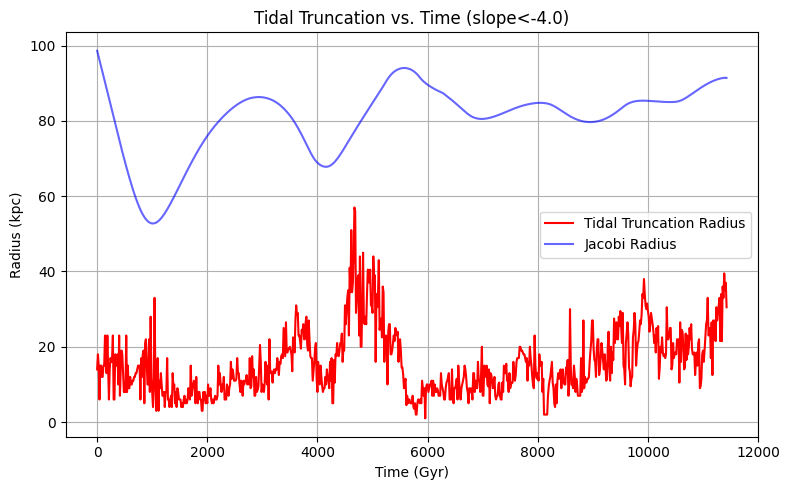

Cell 4.3.2 completed: tidal truncation radius vs. time plot generated.


In [16]:
# ---------------------------------------------------------------
# Cell 4.3.2 — "Plot Tidal Truncation Radius vs. Time"
# Type: Code
# ---------------------------------------------------------------

def plot_tidal_truncation_vs_time(times_trunc, Rtrunc_arr,
                                  times_jacobi=None, rjacobi_arr=None,
                                  slope_threshold=-4.0,
                                  outfig="tidal_truncation_vs_time.png"):
    """
    Plots (time, R_trunc) from slope-based truncation analysis.
    Optionally overlays Jacobi radius vs. time for comparison.

    times_trunc, Rtrunc_arr : np.ndarray
        The arrays from compute_tidal_truncation()
    times_jacobi, rjacobi_arr : np.ndarray or None
        If provided, we overlay the Jacobi radius. 
    slope_threshold : float
        The slope used to define truncation. We'll mention in the title.
    outfig : str
        Filename for saving the plot. If None, won't save.
    """
    import matplotlib.pyplot as plt
    import os

    if len(times_trunc) == 0:
        print("No tidal truncation data to plot.")
        return

    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(times_trunc, Rtrunc_arr, '-', color='red', label='Tidal Truncation Radius')

    # Overlay Jacobi radius if provided
    if times_jacobi is not None and rjacobi_arr is not None and len(times_jacobi) == len(rjacobi_arr) and len(times_jacobi)>0:
        # We might want to re-sort times_jacobi in ascending order
        idx_j = np.argsort(times_jacobi)
        t_j_sorted = times_jacobi[idx_j]
        r_j_sorted = rjacobi_arr[idx_j]
        ax.plot(t_j_sorted, r_j_sorted, '-', color='blue', alpha=0.6, label='Jacobi Radius')

    ax.set_xlabel("Time (Gyr)")
    ax.set_ylabel("Radius (kpc)")
    ax.set_title(f"Tidal Truncation vs. Time (slope<{slope_threshold})")
    ax.grid(True)
    ax.legend()

    # Save figure if desired
    if outfig:
        os.makedirs(PLOTS_DIRECTORY, exist_ok=True)
        outfile = os.path.join(PLOTS_DIRECTORY, outfig)
        plt.tight_layout()
        plt.savefig(outfile, dpi=150)
        print(f"Tidal truncation plot saved to {outfile}")

    plt.show()


# We'll call the plotting function. We'll pass times_jacobi, rjacobi_arr from Section 3.1 for overlay if we want:
plot_tidal_truncation_vs_time(times_trunc, Rtrunc_arr, 
                              times_jacobi, rjacobi_arr,
                              slope_threshold=-4.0,
                              outfig="tidal_truncation_vs_time.png")

print("Cell 4.3.2 completed: tidal truncation radius vs. time plot generated.")


2025-04-01 00:50:57,544 [INFO] Parsed file: M33/M33_000.txt | time=0.0 Gyr | total_particles=14300


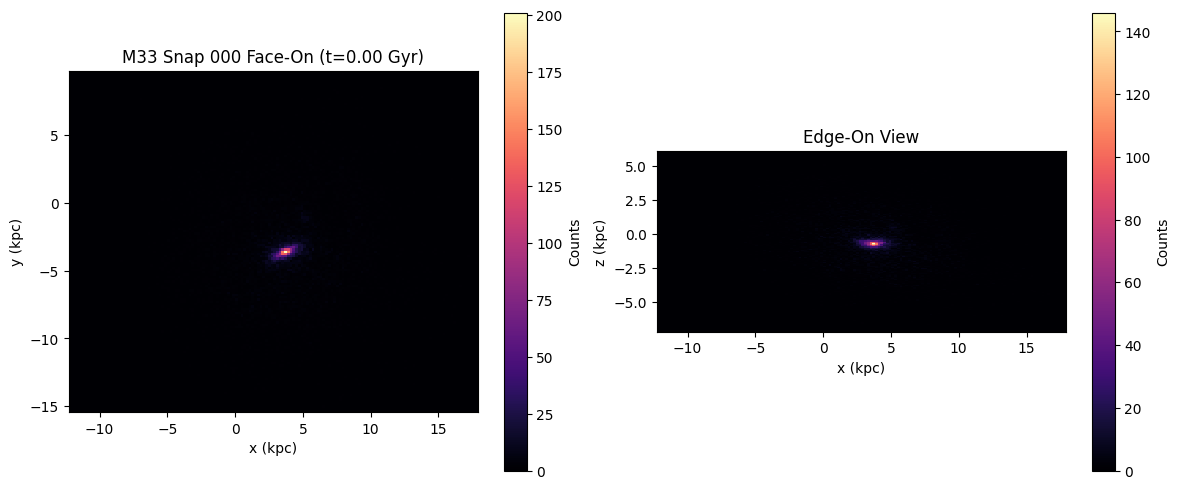

2025-04-01 00:50:58,307 [INFO] demo_face_edge_on: Generated morphological plots for snapshot 0
Cell 5.1.1 completed: single-snapshot morphological demo.


In [17]:
# ---------------------------------------------------------------
# Cell 5.1.1 — "Rotation + 2D Histograms: Single Snapshot Demo"
# Type: Code
# ---------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import logging

def rotate_frame(pos, vel):
    """
    Rotate the coordinate system so that the disk's angular momentum vector 
    is aligned with the +z axis.
    
    Parameters
    ----------
    pos : np.ndarray of shape (N,3)
        3D positions (x,y,z) in kpc.
    vel : np.ndarray of shape (N,3)
        3D velocities (vx,vy,vz) in km/s (or consistent unit).
    
    Returns
    -------
    pos_rot : np.ndarray of shape (N,3)
        Rotated positions.
    vel_rot : np.ndarray of shape (N,3)
        Rotated velocities.
    
    Notes
    -----
    We compute the total angular momentum L = sum(r x v) over all particles,
    then define a rotation that maps L to z-hat using Rodrigues' formula.
    """
    # compute angular momentum
    # L = sum(r_i x v_i), axis=0 => vector
    L = np.sum(np.cross(pos, vel), axis=0)
    L_mag = np.sqrt(np.sum(L**2))
    if L_mag == 0:
        # fallback
        logging.warning("rotate_frame: Angular momentum is zero. No rotation applied.")
        return pos, vel

    L_norm = L / L_mag

    # We want to map L_norm to z-hat => (0,0,1)
    z_hat = np.array([0,0,1], dtype=float)

    # cross product
    v = np.cross(L_norm, z_hat)
    s = np.sqrt(np.sum(v**2))
    c = np.dot(L_norm, z_hat)

    # if s ~ 0 => L is already aligned with z
    if s < 1e-8:
        return pos, vel

    # Rodrigues rotation formula
    I  = np.eye(3)
    vx = np.array([[0,      -v[2],   v[1]],
                   [v[2],   0,      -v[0]],
                   [-v[1],  v[0],    0   ]])
    
    R = I + vx + (vx @ vx)*((1 - c)/(s**2))

    pos_rot = (R @ pos.T).T
    vel_rot = (R @ vel.T).T

    return pos_rot, vel_rot


def demo_face_edge_on(snapshot_index=0, filter_disk=False, disk_type=2):
    """
    Demonstrates how to:
      1) pick M33 snapshot,
      2) parse & center on M33,
      3) optionally filter 'disk' particles (if filter_disk=True, we pick type=2),
      4) rotate coords so disk angular momentum is along +z,
      5) produce face-on & edge-on 2D histograms.
    
    The plots are displayed inline and saved in 'plots/' directory.
    """
    # parse
    file_m33 = f"{M33_DIRECTORY}M33_{snapshot_index:03d}.txt"
    t_m33, count_m33, data_m33 = parse_galaxy_file(file_m33)
    (ptype, mass, x, y, z, vx, vy, vz) = data_m33

    # shift by M33 COM
    xcom, ycom, zcom = center_of_mass(x, y, z, mass)
    x_shift = x - xcom
    y_shift = y - ycom
    z_shift = z - zcom

    vx_shift = vx  # We might shift velocities by M33 COM velocity if needed
    vy_shift = vy
    vz_shift = vz

    # optionally filter disk
    if filter_disk:
        disk_mask = (ptype == disk_type)
        x_shift = x_shift[disk_mask]
        y_shift = y_shift[disk_mask]
        z_shift = z_shift[disk_mask]
        vx_shift = vx_shift[disk_mask]
        vy_shift = vy_shift[disk_mask]
        vz_shift = vz_shift[disk_mask]

    # combine pos, vel for rotation
    pos_arr = np.column_stack((x_shift, y_shift, z_shift))
    vel_arr = np.column_stack((vx_shift, vy_shift, vz_shift))

    # rotate
    pos_rot, vel_rot = rotate_frame(pos_arr, vel_arr)

    # face-on => (x_rot, y_rot)
    # edge-on => (x_rot, z_rot) or (y_rot, z_rot)
    x_rot = pos_rot[:,0]
    y_rot = pos_rot[:,1]
    z_rot = pos_rot[:,2]

    # 2D hist face-on
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

    nbins = 150
    h1 = ax1.hist2d(x_rot, y_rot, bins=nbins, cmap='magma')
    ax1.set_xlabel("x (kpc)")
    ax1.set_ylabel("y (kpc)")
    ax1.set_title(f"M33 Snap {snapshot_index:03d} Face-On (t={t_m33:.2f} Gyr)")
    ax1.set_aspect('equal', 'box')

    # edge-on (x,z)
    h2 = ax2.hist2d(x_rot, z_rot, bins=nbins, cmap='magma')
    ax2.set_xlabel("x (kpc)")
    ax2.set_ylabel("z (kpc)")
    ax2.set_title(f"Edge-On View")
    ax2.set_aspect('equal', 'box')

    fig.colorbar(h1[3], ax=ax1, label="Counts")
    fig.colorbar(h2[3], ax=ax2, label="Counts")

    # save
    plt.tight_layout()
    os.makedirs(PLOTS_DIRECTORY, exist_ok=True)
    outfig = os.path.join(PLOTS_DIRECTORY, f"M33_{snapshot_index:03d}_MorphDemo.png")
    plt.savefig(outfig, dpi=150)
    plt.show()
    
    logging.info(f"demo_face_edge_on: Generated morphological plots for snapshot {snapshot_index}")


# Let's do a single snapshot demo with or without filtering
demo_face_edge_on(snapshot_index=0, filter_disk=True)
print("Cell 5.1.1 completed: single-snapshot morphological demo.")


In [20]:
# ---------------------------------------------------------------
# Cell 5.1.2 — "Automated Morphology Plots for All Snapshots (Side-by-Side)"
# Type: Code
# ---------------------------------------------------------------
import glob
import logging
import numpy as np
import matplotlib.pyplot as plt
import os

def generate_morphology_plots_all_snaps_side_by_side(filter_disk=True, disk_type=2):
    """
    Loops over M33 snapshots, applies coordinate rotation so the disk is face-on,
    and saves a single image with two subplots side by side (12x6):
      - Left  => Face-On (x vs. y)
      - Right => Edge-On (x vs. z)

    The resulting figure is saved as 'plots/M33_morph_<snap>.png'.

    Parameters
    ----------
    filter_disk : bool
        If True, only use particles with type == disk_type
    disk_type : int
        The particle type for the 'disk' (commonly 2)

    Returns
    -------
    None (plots are generated & saved)
    """
    # Find all M33 snapshot files
    m33_files = sorted(glob.glob(f"{M33_DIRECTORY}M33_*.txt"))

    for f in m33_files:
        snap_idx = get_snapshot_index(f)
        if snap_idx is None:
            continue

        # Parse the M33 snapshot
        t_m33, count_m33, data_m33 = parse_galaxy_file(f)
        (ptype, mass, x, y, z, vx, vy, vz) = data_m33

        # Center M33 by subtracting the COM
        xcom, ycom, zcom = center_of_mass(x, y, z, mass)
        x_shift = x - xcom
        y_shift = y - ycom
        z_shift = z - zcom

        vx_shift = vx
        vy_shift = vy
        vz_shift = vz

        # If requested, filter down to only disk particles (type==disk_type)
        if filter_disk:
            disk_mask = (ptype == disk_type)
            x_shift = x_shift[disk_mask]
            y_shift = y_shift[disk_mask]
            z_shift = z_shift[disk_mask]
            vx_shift = vx_shift[disk_mask]
            vy_shift = vy_shift[disk_mask]
            vz_shift = vz_shift[disk_mask]

        # If too few particles remain, skip plotting
        if len(x_shift) < 10:
            logging.warning(
                f"Snapshot {snap_idx}: only {len(x_shift)} disk particles, skipping figure."
            )
            continue

        # Combine positions & velocities for disk rotation
        pos_arr = np.column_stack((x_shift, y_shift, z_shift))
        vel_arr = np.column_stack((vx_shift, vy_shift, vz_shift))

        # Rotate to align the disk angular momentum with +z
        pos_rot, vel_rot = rotate_frame(pos_arr, vel_arr)
        x_rot = pos_rot[:, 0]
        y_rot = pos_rot[:, 1]
        z_rot = pos_rot[:, 2]

        # Create a single figure with 1 row and 2 columns
        # Size 12 wide, 6 high
        fig, (ax_face, ax_edge) = plt.subplots(
            nrows=1, ncols=2, figsize=(12, 6)
        )

        nbins = 150

        # Left subplot: Face-On (x_rot vs. y_rot)
        h_face = ax_face.hist2d(x_rot, y_rot, bins=nbins, cmap='magma')
        ax_face.set_xlabel("x (kpc)")
        ax_face.set_ylabel("y (kpc)")
        ax_face.set_title(f"M33_{snap_idx:03d} Face-On (t={t_m33:.2f} Gyr)")
        ax_face.set_aspect('equal', 'box')
        fig.colorbar(h_face[3], ax=ax_face, label="Counts")

        # Right subplot: Edge-On (x_rot vs. z_rot)
        h_edge = ax_edge.hist2d(x_rot, z_rot, bins=nbins, cmap='magma')
        ax_edge.set_xlabel("x (kpc)")
        ax_edge.set_ylabel("z (kpc)")
        ax_edge.set_title("Edge-On View")
        ax_edge.set_aspect('equal', 'box')
        fig.colorbar(h_edge[3], ax=ax_edge, label="Counts")

        # Save to disk
        os.makedirs(PLOTS_DIRECTORY, exist_ok=True)
        outfig = os.path.join(PLOTS_DIRECTORY, f"M33_morph_{snap_idx:03d}.png")

        plt.tight_layout()
        plt.savefig(outfig, dpi=150)
        plt.close(fig)

        logging.info(
            f"Snapshot {snap_idx}: combined face-on & edge-on figure saved -> {outfig}"
        )


# Example usage:
generate_morphology_plots_all_snaps_side_by_side(filter_disk=True, disk_type=2)
print("Cell 5.1.2 updated: side-by-side face-on & edge-on morphological plots for each snapshot, 12x6 figure size.")


2025-04-01 01:17:21,843 [INFO] Parsed file: M33/M33_000.txt | time=0.0 Gyr | total_particles=14300
2025-04-01 01:17:22,490 [INFO] Snapshot 0: combined face-on & edge-on figure saved -> plots/M33_morph_000.png
2025-04-01 01:17:22,576 [INFO] Parsed file: M33/M33_001.txt | time=14.2857 Gyr | total_particles=14300
2025-04-01 01:17:23,147 [INFO] Snapshot 1: combined face-on & edge-on figure saved -> plots/M33_morph_001.png
2025-04-01 01:17:23,214 [INFO] Parsed file: M33/M33_002.txt | time=28.57142 Gyr | total_particles=14300
2025-04-01 01:17:23,812 [INFO] Snapshot 2: combined face-on & edge-on figure saved -> plots/M33_morph_002.png
2025-04-01 01:17:23,877 [INFO] Parsed file: M33/M33_003.txt | time=42.85712 Gyr | total_particles=14300
2025-04-01 01:17:24,479 [INFO] Snapshot 3: combined face-on & edge-on figure saved -> plots/M33_morph_003.png
2025-04-01 01:17:24,588 [INFO] Parsed file: M33/M33_004.txt | time=57.14285 Gyr | total_particles=14300
2025-04-01 01:17:25,150 [INFO] Snapshot 4: com

In [21]:
'''
# ---------------------------------------------------------------
# Cell 5.2.1 — "Spiral Arm Identification & Pitch Angle Function"
# Type: Code
# ---------------------------------------------------------------

import numpy as np
from scipy.optimize import curve_fit
import logging

def log_spiral_func(R, theta0, m):
    """
    Defines a logarithmic spiral in polar form:
        theta(R) = theta0 + m * ln(R)

    We'll fit the data (R, theta) to this function 
    to find the best (theta0, m).

    Then the pitch angle p is given by:
        p = arctan(1/m)
    if we adopt the form  theta = c + m ln(R).
    """
    return theta0 + m * np.log(R)


def measure_spiral_pitch_angle(pos_rot, rmin=1.0, rmax=15.0):
    """
    Attempts to measure the spiral pitch angle of a disk 
    by fitting a log-spiral:  theta = c + m ln(R).

    Steps:
      1) Convert (x_rot,y_rot) -> (R,theta) in plane
      2) Restrict data to rmin < R < rmax
      3) Use curve_fit to find (theta0, m)
      4) pitch_angle = arctan(1/m)

    Returns
    -------
    pitch_angle : float
        pitch angle in degrees
    theta0_best : float
        intercept in the log-spiral fit (radians)
    m_best : float
        slope in the log-spiral fit
    """
    x = pos_rot[:,0]
    y = pos_rot[:,1]

    R = np.sqrt(x**2 + y**2)
    # angle range is -pi..pi from arctan2
    theta = np.arctan2(y, x)

    # filter radius
    mask = (R > rmin) & (R < rmax)
    R_cut = R[mask]
    theta_cut = theta[mask]

    # If no data, return NaN
    if len(R_cut) < 2:
        logging.warning("measure_spiral_pitch_angle: Not enough points in [rmin,rmax]. Returning NaN.")
        return np.nan, np.nan, np.nan

    # We'll attempt to unwrap theta so it's monotonic-ish for the fit.
    # But for multiple arms, or a large scatter, a single log-spiral might not capture it well.
    # For a naive approach, let's just shift negative thetas to positive so we get 0..2pi.
    # A more robust method might do a partial unwrapping in segments.
    # We'll do a simple approach:
    theta_positive = np.where(theta_cut<0, theta_cut+2*np.pi, theta_cut)

    # initial guess
    guess_theta0 = 0.0
    guess_m      = 1.0

    # define the function in terms of R
    def log_spiral_fit(R, theta0, m):
        return theta0 + m * np.log(R)

    # curve_fit
    try:
        popt, pcov = curve_fit(log_spiral_fit, R_cut, theta_positive,
                               p0=[guess_theta0, guess_m],
                               maxfev=2000)
        theta0_best, m_best = popt
    except RuntimeError:
        logging.warning("measure_spiral_pitch_angle: curve_fit did not converge.")
        return np.nan, np.nan, np.nan

    # pitch angle in degrees
    # form:  theta(R) = c + m ln(R) => R = exp((theta-c)/m)
    # slope is dtheta/d(lnR) = m => pitch angle p = arctan(1/m).
    pitch_angle_radians = np.arctan(1.0/m_best)
    pitch_angle_degs = np.degrees(pitch_angle_radians)

    return pitch_angle_degs, theta0_best, m_best

print("Cell 5.2.1 completed: measure_spiral_pitch_angle() function defined.")
'''

'\n# ---------------------------------------------------------------\n# Cell 5.2.1 — "Spiral Arm Identification & Pitch Angle Function"\n# Type: Code\n# ---------------------------------------------------------------\n\nimport numpy as np\nfrom scipy.optimize import curve_fit\nimport logging\n\ndef log_spiral_func(R, theta0, m):\n    """\n    Defines a logarithmic spiral in polar form:\n        theta(R) = theta0 + m * ln(R)\n\n    We\'ll fit the data (R, theta) to this function \n    to find the best (theta0, m).\n\n    Then the pitch angle p is given by:\n        p = arctan(1/m)\n    if we adopt the form  theta = c + m ln(R).\n    """\n    return theta0 + m * np.log(R)\n\n\ndef measure_spiral_pitch_angle(pos_rot, rmin=1.0, rmax=15.0):\n    """\n    Attempts to measure the spiral pitch angle of a disk \n    by fitting a log-spiral:  theta = c + m ln(R).\n\n    Steps:\n      1) Convert (x_rot,y_rot) -> (R,theta) in plane\n      2) Restrict data to rmin < R < rmax\n      3) Use curve_fit

In [22]:
'''
# ---------------------------------------------------------------
# Cell 5.2.2 — "Spiral Arm Timeseries: Pitch Angle vs. Time"
# Type: Code
# ---------------------------------------------------------------

import matplotlib.pyplot as plt

def compute_spiral_pitch_timeseries(rmin=1.0, rmax=15.0, filter_disk=True, disk_type=2,
                                    save_results=SAVE_INTERMEDIATE_RESULTS):
    """
    For each M33 snapshot:
      1) parse, center, optionally filter disk
      2) rotate to face-on
      3) measure pitch angle in [rmin, rmax]
      4) store (time, pitch_angle)
    Returns arrays => times_spiral, pitch_arr

    If save_results=True, also saves 'spiral_pitch_vs_time.npy' in results folder.
    """
    import glob, os
    m33_files = sorted(glob.glob(f"{M33_DIRECTORY}M33_*.txt"))

    times_list = []
    pitch_list = []

    for f in m33_files:
        snap_idx = get_snapshot_index(f)
        if snap_idx is None:
            continue

        # parse
        t_m33, count_m33, data_m33 = parse_galaxy_file(f)
        (ptype, mass, x, y, z, vx, vy, vz) = data_m33

        # shift M33
        xcom, ycom, zcom = center_of_mass(x, y, z, mass)
        x_shift = x - xcom
        y_shift = y - ycom
        z_shift = z - zcom

        vx_shift = vx
        vy_shift = vy
        vz_shift = vz

        # optionally filter for disk
        if filter_disk:
            disk_mask = (ptype == disk_type)
            x_shift = x_shift[disk_mask]
            y_shift = y_shift[disk_mask]
            z_shift = z_shift[disk_mask]
            vx_shift = vx_shift[disk_mask]
            vy_shift = vy_shift[disk_mask]
            vz_shift = vz_shift[disk_mask]

        if len(x_shift) < 50:
            # not enough disk points to measure arms
            pitch_list.append(np.nan)
            times_list.append(t_m33)
            logging.info(f"Snapshot {snap_idx}: <50 disk particles, skipping spiral measurement.")
            continue

        # rotate
        pos_arr = np.column_stack((x_shift, y_shift, z_shift))
        vel_arr = np.column_stack((vx_shift, vy_shift, vz_shift))
        pos_rot, vel_rot = rotate_frame(pos_arr, vel_arr)
        # measure pitch angle
        pitch_angle, theta0_best, m_best = measure_spiral_pitch_angle(pos_rot, rmin=rmin, rmax=rmax)

        pitch_list.append(pitch_angle)
        times_list.append(t_m33)

        logging.info(f"Snapshot {snap_idx}: time={t_m33:.2f} => pitch={pitch_angle:.2f} deg")

    times_spiral = np.array(times_list)
    pitch_arr    = np.array(pitch_list)

    # sort by time
    idx = np.argsort(times_spiral)
    times_spiral = times_spiral[idx]
    pitch_arr    = pitch_arr[idx]

    # optionally save
    if save_results and len(times_spiral)>0:
        os.makedirs(RESULTS_DIRECTORY, exist_ok=True)
        outfile = os.path.join(RESULTS_DIRECTORY, "spiral_pitch_vs_time.npy")
        np.save(outfile, np.column_stack((times_spiral, pitch_arr)))
        logging.info(f"Spiral pitch results saved to {outfile}")

    return times_spiral, pitch_arr


def plot_spiral_pitch_timeseries(times_spiral, pitch_arr,
                                 outfig="spiral_pitch_vs_time.png"):
    """
    Plots pitch angle vs. time. If pitch_arr has many NaNs,
    we'll just show them as gaps or drop them.

    times_spiral : array
    pitch_arr    : array
    """
    if len(times_spiral)==0:
        print("No spiral pitch data to plot.")
        return

    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(times_spiral, pitch_arr, '-', color='red', label='Spiral Pitch Angle')

    ax.set_xlabel("Time (Gyr)")
    ax.set_ylabel("Pitch Angle (deg)")
    ax.set_title("Spiral Pitch Angle vs. Time")
    ax.grid(True)
    ax.legend()

    # summary
    valid_pitch = pitch_arr[~np.isnan(pitch_arr)]
    if len(valid_pitch)>1:
        initial = valid_pitch[0]
        final   = valid_pitch[-1]
        # difference or something
        diff = final-initial
        msg = f"From {initial:.1f} deg to {final:.1f} deg (delta={diff:.1f})"
        ax.text(0.05, 0.85, msg, transform=ax.transAxes,
                fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    if outfig:
        os.makedirs(PLOTS_DIRECTORY, exist_ok=True)
        outfile = os.path.join(PLOTS_DIRECTORY, outfig)
        plt.tight_layout()
        plt.savefig(outfile, dpi=150)
        print(f"Spiral pitch timeseries plot saved to {outfile}")

    plt.show()
    print("\nDone: pitch angle timeseries plot.\n")


# We'll run the timeseries measurement and plot
times_spiral, pitch_arr = compute_spiral_pitch_timeseries(rmin=1.0, rmax=15.0, filter_disk=True)
plot_spiral_pitch_timeseries(times_spiral, pitch_arr)

print("Cell 5.2.2 completed: spiral arm timeseries measurement & plot generated.")
'''

'\n# ---------------------------------------------------------------\n# Cell 5.2.2 — "Spiral Arm Timeseries: Pitch Angle vs. Time"\n# Type: Code\n# ---------------------------------------------------------------\n\nimport matplotlib.pyplot as plt\n\ndef compute_spiral_pitch_timeseries(rmin=1.0, rmax=15.0, filter_disk=True, disk_type=2,\n                                    save_results=SAVE_INTERMEDIATE_RESULTS):\n    """\n    For each M33 snapshot:\n      1) parse, center, optionally filter disk\n      2) rotate to face-on\n      3) measure pitch angle in [rmin, rmax]\n      4) store (time, pitch_angle)\n    Returns arrays => times_spiral, pitch_arr\n\n    If save_results=True, also saves \'spiral_pitch_vs_time.npy\' in results folder.\n    """\n    import glob, os\n    m33_files = sorted(glob.glob(f"{M33_DIRECTORY}M33_*.txt"))\n\n    times_list = []\n    pitch_list = []\n\n    for f in m33_files:\n        snap_idx = get_snapshot_index(f)\n        if snap_idx is None:\n            cont

2025-04-01 09:22:33,118 [INFO] Parsed file: M33/M33_000.txt | time=0.0 Gyr | total_particles=14300
2025-04-01 09:22:33,127 [INFO] Snapshot 000: time=0.00, pitch=79.86 deg
2025-04-01 09:22:33,182 [INFO] Parsed file: M33/M33_001.txt | time=14.2857 Gyr | total_particles=14300
2025-04-01 09:22:33,192 [INFO] Snapshot 001: time=14.29, pitch=78.05 deg
2025-04-01 09:22:33,243 [INFO] Parsed file: M33/M33_002.txt | time=28.57142 Gyr | total_particles=14300
2025-04-01 09:22:33,256 [INFO] Snapshot 002: time=28.57, pitch=85.01 deg
2025-04-01 09:22:33,306 [INFO] Parsed file: M33/M33_003.txt | time=42.85712 Gyr | total_particles=14300
2025-04-01 09:22:33,316 [INFO] Snapshot 003: time=42.86, pitch=88.95 deg
2025-04-01 09:22:33,357 [INFO] Parsed file: M33/M33_004.txt | time=57.14285 Gyr | total_particles=14300
2025-04-01 09:22:33,366 [INFO] Snapshot 004: time=57.14, pitch=87.48 deg
2025-04-01 09:22:33,405 [INFO] Parsed file: M33/M33_005.txt | time=71.42857 Gyr | total_particles=14300
2025-04-01 09:22:3

/var/folders/rw/vhqnc3wj2t7fqp8k4fwy4y1w0000gn/T/ipykernel_51183/1299895579.py:89: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(


2025-04-01 09:22:44,885 [INFO] Parsed file: M33/M33_243.txt | time=3471.42856 Gyr | total_particles=14300
2025-04-01 09:22:44,892 [INFO] Snapshot 243: time=3471.43, pitch=34.83 deg
2025-04-01 09:22:44,929 [INFO] Parsed file: M33/M33_244.txt | time=3485.71428 Gyr | total_particles=14300
2025-04-01 09:22:44,935 [INFO] Snapshot 244: time=3485.71, pitch=29.87 deg
2025-04-01 09:22:44,974 [INFO] Parsed file: M33/M33_245.txt | time=3499.99998 Gyr | total_particles=14300
2025-04-01 09:22:44,980 [INFO] Snapshot 245: time=3500.00, pitch=22.63 deg
2025-04-01 09:22:45,018 [INFO] Parsed file: M33/M33_246.txt | time=3514.2857 Gyr | total_particles=14300
2025-04-01 09:22:45,025 [INFO] Snapshot 246: time=3514.29, pitch=14.60 deg
2025-04-01 09:22:45,062 [INFO] Parsed file: M33/M33_247.txt | time=3528.57143 Gyr | total_particles=14300
2025-04-01 09:22:45,069 [INFO] Snapshot 247: time=3528.57, pitch=7.97 deg
2025-04-01 09:22:45,107 [INFO] Parsed file: M33/M33_248.txt | time=3542.85713 Gyr | total_particl

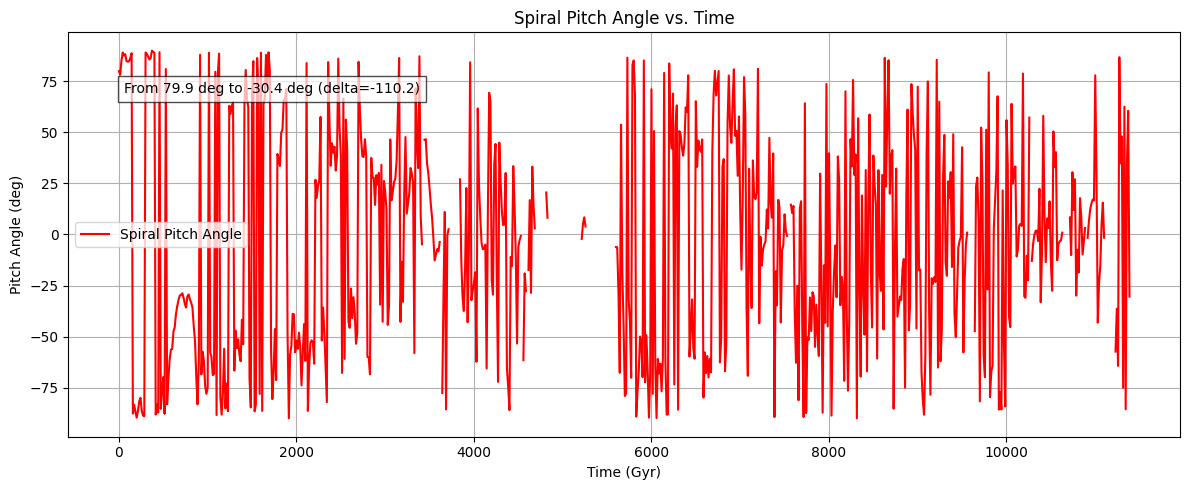


Done: pitch angle timeseries plot.


<<< Combined Spiral Pitch Angle Code Completed >>>


In [24]:
# 5.2.1 and 5.2.2
# --------------------------------------------------------------------------------
# COMBINED CELL: Spiral Arm Pitch Angle Computation & Timeseries
# --------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import logging
from scipy.optimize import curve_fit
import os

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# 1) Spiral-fitting function
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def log_spiral_func(R, theta0, m):
    """
    Defines a logarithmic spiral in polar form:
        theta(R) = theta0 + m * ln(R)

    We'll fit (R, theta) data to find best (theta0, m).
    Then pitch angle p = arctan(1/m) for the form theta = c + m ln(R).
    """
    return theta0 + m * np.log(R)

def measure_spiral_pitch_angle(pos_rot, rmin=1.0, rmax=15.0, 
                               min_points_for_fit=20):
    """
    Attempts to measure the spiral pitch angle of a disk 
    by fitting a log-spiral:  theta = c + m ln(R).

    Steps:
      1) Convert (x_rot, y_rot) -> (R, theta)
      2) Restrict data to rmin < R < rmax
      3) Use curve_fit(...) to find (theta0, m)
      4) pitch_angle = arctan(1/m) in degrees

    Parameters
    ----------
    pos_rot : np.ndarray shape (N,3)
        Rotated star/disk positions (x,y,z). We only use x,y for the spiral fit.
    rmin, rmax : float
        The radial bounds (kpc) within which we attempt to find a spiral.
        If the disk is smaller or bigger, many points may be outside.
    min_points_for_fit : int
        The minimum number of points required to attempt a log-spiral fit.

    Returns
    -------
    pitch_angle_degs : float
        Measured pitch angle in degrees (NaN if not enough data).
    theta0_best : float
        The best-fit intercept (in radians).
    m_best : float
        The best-fit slope in the log-spiral eqn.
    """
    # Unpack x,y from the rotated positions
    x = pos_rot[:,0]
    y = pos_rot[:,1]

    # Convert to polar coords
    R = np.sqrt(x**2 + y**2)          # radius
    theta = np.arctan2(y, x)          # angle in -pi..pi

    # Filter based on radial range
    mask = (R > rmin) & (R < rmax)
    R_cut = R[mask]
    theta_cut = theta[mask]

    # If not enough data
    if len(R_cut) < min_points_for_fit:
        logging.warning(f"measure_spiral_pitch_angle: Only {len(R_cut)} points "
                        f"in [r={rmin},{rmax}], need >= {min_points_for_fit}. Returning NaN.")
        return np.nan, np.nan, np.nan

    # Simple "unwrapping": shift negative angles to 0..2pi range
    # (Better methods can do partial unwrapping or handle multiple arms.)
    theta_positive = np.where(theta_cut < 0, theta_cut + 2*np.pi, theta_cut)

    # We'll define a local function for the fit
    def log_spiral_fit(R_array, theta0, m):
        return theta0 + m * np.log(R_array)

    # Initial guesses
    guess_theta0 = 0.0
    guess_m      = 1.0

    try:
        popt, pcov = curve_fit(
            log_spiral_fit, 
            R_cut, 
            theta_positive,
            p0=[guess_theta0, guess_m],
            maxfev=2000
        )
        theta0_best, m_best = popt
    except RuntimeError:
        logging.warning("measure_spiral_pitch_angle: curve_fit did not converge. Returning NaN.")
        return np.nan, np.nan, np.nan

    # pitch angle => p = arctan(1/m) in radians, then convert to degrees
    pitch_angle_radians = np.arctan(1.0 / m_best)
    pitch_angle_degs    = np.degrees(pitch_angle_radians)

    return pitch_angle_degs, theta0_best, m_best


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# 2) Timeseries function
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def compute_spiral_pitch_timeseries(
    rmin=1.0, 
    rmax=15.0, 
    filter_disk=True, 
    disk_type=2,
    min_points_for_fit=20,       # you can lower this if you want to fit with fewer points
    save_results=SAVE_INTERMEDIATE_RESULTS
):
    """
    Loops over M33 snapshots to measure pitch angle at each time.

    Steps:
      1) parse data
      2) center M33
      3) optionally filter for disk only
      4) rotate to face-on (rotate_frame) 
      5) measure pitch angle in [rmin, rmax] with measure_spiral_pitch_angle()

    Parameters
    ----------
    rmin, rmax : float
        radial bounds for the spiral-fitting (kpc).
    filter_disk : bool
        If True, only pick type=disk_type particles.
    disk_type : int
        Particle type for the disk (commonly 2).
    min_points_for_fit : int
        min # of points to do the log-spiral curve_fit. 
        If fewer, returns NaN for that snapshot.
    save_results : bool
        If True, saves the final (time, pitch) to 'spiral_pitch_vs_time.npy'.

    Returns
    -------
    times_spiral : np.ndarray
    pitch_arr    : np.ndarray
        Both sorted by time ascending.
    """
    import glob
    m33_files = sorted(glob.glob(f"{M33_DIRECTORY}M33_*.txt"))

    times_list  = []
    pitch_list  = []

    for f in m33_files:
        snap_idx = get_snapshot_index(f)
        if snap_idx is None:
            continue

        # parse
        t_m33, count_m33, data_m33 = parse_galaxy_file(f)
        (ptype, mass, x, y, z, vx, vy, vz) = data_m33

        # shift M33 by COM
        xcom, ycom, zcom = center_of_mass(x, y, z, mass)
        x_shift = x - xcom
        y_shift = y - ycom
        z_shift = z - zcom
        vx_shift = vx
        vy_shift = vy
        vz_shift = vz

        # optionally filter to disk only
        if filter_disk:
            disk_mask = (ptype == disk_type)
            x_shift = x_shift[disk_mask]
            y_shift = y_shift[disk_mask]
            z_shift = z_shift[disk_mask]
            vx_shift = vx_shift[disk_mask]
            vy_shift = vy_shift[disk_mask]
            vz_shift = vz_shift[disk_mask]

        # if very few disk points, skip
        if len(x_shift) < 50:
            pitch_list.append(np.nan)
            times_list.append(t_m33)
            logging.info(f"Snapshot {snap_idx}: <50 disk particles => skip spiral measurement.")
            continue

        # rotate to face-on
        pos_arr = np.column_stack((x_shift, y_shift, z_shift))
        vel_arr = np.column_stack((vx_shift, vy_shift, vz_shift))
        pos_rot, vel_rot = rotate_frame(pos_arr, vel_arr)

        # measure pitch angle
        pitch_angle, theta0_best, m_best = measure_spiral_pitch_angle(
            pos_rot, 
            rmin=rmin, 
            rmax=rmax,
            min_points_for_fit=min_points_for_fit
        )

        pitch_list.append(pitch_angle)
        times_list.append(t_m33)

        logging.info(f"Snapshot {snap_idx:03d}: time={t_m33:.2f}, pitch={pitch_angle:.2f} deg")

    # convert to arrays and sort by time
    times_spiral = np.array(times_list)
    pitch_arr    = np.array(pitch_list)
    idx = np.argsort(times_spiral)
    times_spiral = times_spiral[idx]
    pitch_arr    = pitch_arr[idx]

    # optionally save
    if save_results and len(times_spiral)>0:
        os.makedirs(RESULTS_DIRECTORY, exist_ok=True)
        outfile = os.path.join(RESULTS_DIRECTORY, "spiral_pitch_vs_time.npy")
        np.save(outfile, np.column_stack((times_spiral, pitch_arr)))
        logging.info(f"Spiral pitch results saved to {outfile}")

    return times_spiral, pitch_arr


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# 3) Plot function
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def plot_spiral_pitch_timeseries(times_spiral, pitch_arr, outfig="spiral_pitch_vs_time.png"):
    """
    Plots pitch angle vs. time, ignoring NaNs. 
    If there's a large gap in times, that often indicates
    many snapshots returned NaN (the disk wasn't in the chosen radial range).

    times_spiral : np.ndarray
    pitch_arr    : np.ndarray
        (NaNs for those with insufficient data)
    outfig : str
        filename to save, or None to skip saving
    """
    if len(times_spiral) == 0:
        print("No spiral pitch data to plot at all.")
        return

    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(times_spiral, pitch_arr, '-', color='red', label='Spiral Pitch Angle')

    ax.set_xlabel("Time (Gyr)")
    ax.set_ylabel("Pitch Angle (deg)")
    ax.set_title("Spiral Pitch Angle vs. Time")
    ax.grid(True)
    ax.legend()

    # Summarize initial & final pitch angles if we have multiple valid points
    valid_pitch = pitch_arr[~np.isnan(pitch_arr)]
    if len(valid_pitch) > 1:
        initial = valid_pitch[0]
        final   = valid_pitch[-1]
        diff = final - initial
        msg = f"From {initial:.1f} deg to {final:.1f} deg (delta={diff:.1f})"
        ax.text(0.05, 0.85, msg, transform=ax.transAxes,
                fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    if outfig:
        os.makedirs(PLOTS_DIRECTORY, exist_ok=True)
        outfile = os.path.join(PLOTS_DIRECTORY, outfig)
        plt.tight_layout()
        plt.savefig(outfile, dpi=150)
        print(f"Spiral pitch timeseries plot saved to {outfile}")

    plt.show()
    print("\nDone: pitch angle timeseries plot.\n")


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# 4) Example usage in a single code cell
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# We'll run the timeseries measurement & plotting with default rmin=1.0, rmax=15.0
# To experiment, adjust the function call below:
'''
times_spiral, pitch_arr = compute_spiral_pitch_timeseries(
    rmin=1.0,     # <-- Try lowering to 0.5 or 0.1 if your disk shrinks below 1 kpc
    rmax=15.0,    # <-- Try raising to 20 if disk extends further at some epochs
    filter_disk=True, 
    disk_type=2,
    min_points_for_fit=20  # <-- Lower to 10 if you want a fit w/ fewer points
)

plot_spiral_pitch_timeseries(times_spiral, pitch_arr, outfig="spiral_pitch_vs_time.png")


# --------------------------------------------------------------------------------
#  BELOW are some "alternate lines" you might try by commenting/uncommenting:
# --------------------------------------------------------------------------------

times_spiral, pitch_arr = compute_spiral_pitch_timeseries(
    rmin=0.5,   # smaller rmin to catch smaller disk radius
    rmax=25.0,  # bigger rmax
    filter_disk=True,
    disk_type=2,
    min_points_for_fit=10  # accept fewer points
)
plot_spiral_pitch_timeseries(times_spiral, pitch_arr, outfig="spiral_pitch_vs_time_altA.png")
'''

times_spiral, pitch_arr = compute_spiral_pitch_timeseries(
    rmin=1.0,
    rmax=15.0,
    filter_disk=False,  # see if using ALL stellar particles helps
    disk_type=2,
    min_points_for_fit=2
)
plot_spiral_pitch_timeseries(times_spiral, pitch_arr, outfig="spiral_pitch_vs_time_altB.png")

print("\n<<< Combined Spiral Pitch Angle Code Completed >>>")


In [25]:
# ---------------------------------------------------------------
# Cell 5.3.1 — "Warp Computation vs. Radius"
# Type: Code
# ---------------------------------------------------------------

import numpy as np
import logging

def plane_normal_svd(x, y, z):
    """
    Computes the best-fit plane normal using SVD on the (x,y,z) points.
    We find the mean, shift, then do an SVD. The last singular vector
    is the plane normal.

    Returns
    -------
    normal : np.ndarray of shape (3,)
        Unit normal vector to the best-fit plane.
    """
    coords = np.column_stack((x, y, z))
    centroid = coords.mean(axis=0)
    coords_centered = coords - centroid
    if coords_centered.shape[0] < 3:
        return np.array([0,0,1], dtype=float)  # fallback

    # SVD
    u, s, vh = np.linalg.svd(coords_centered, full_matrices=False)
    # The last column of vh is the direction with smallest variance => plane normal
    normal = vh[-1, :]
    norm_mag = np.linalg.norm(normal)
    if norm_mag < 1e-10:
        return np.array([0,0,1], dtype=float)
    return normal / norm_mag


def measure_warp_angles(pos_rot, nbins=5, rmax=30.0):
    """
    Subdivide radius in nbins from [0, rmax], measure the local plane normal 
    in each annulus, compare to the global disk normal => warp angle at that radius.

    Steps:
      1) pos_rot is shape (N,3), presumably face-on or some orientation. 
         But here we'll do a generic approach:
         We'll define 'global normal' from the entire disk (plane_normal_svd).
      2) Subdivide R = sqrt(x^2+y^2) into nbins up to rmax. 
      3) For each annulus, compute the local normal via plane_normal_svd() 
         and measure the angle wrt global normal.

    Returns
    -------
    r_mid : np.ndarray
        radial midpoints for each annulus
    warp_angle : np.ndarray
        angle in degrees of local plane wrt global plane
    """
    x = pos_rot[:,0]
    y = pos_rot[:,1]
    z = pos_rot[:,2]
    R = np.sqrt(x**2 + y**2)

    # "global" normal from entire disk
    global_normal = plane_normal_svd(x, y, z)

    # define radial bins
    edges = np.linspace(0, rmax, nbins+1)
    r_mid = 0.5*(edges[:-1] + edges[1:])
    warp_angle = np.zeros(nbins) + np.nan

    for i in range(nbins):
        r_in  = edges[i]
        r_out = edges[i+1]
        mask  = (R >= r_in) & (R < r_out)
        x_sub = x[mask]
        y_sub = y[mask]
        z_sub = z[mask]
        if len(x_sub) < 10:
            # not enough points
            continue
        local_normal = plane_normal_svd(x_sub, y_sub, z_sub)
        # angle wrt global normal
        dot_val = np.dot(local_normal, global_normal)
        dot_val = max(min(dot_val, 1.0), -1.0)  # clamp
        angle_rad = np.arccos(dot_val)
        angle_deg = np.degrees(angle_rad)
        warp_angle[i] = angle_deg

    return r_mid, warp_angle

print("Cell 5.3.1 completed: measure_warp_angles() function defined.")


Cell 5.3.1 completed: measure_warp_angles() function defined.


In [26]:
# ---------------------------------------------------------------
# Cell 5.3.2 — "Scale Height Computation"
# Type: Code
# ---------------------------------------------------------------

def measure_scale_height(pos_rot, nbins=5, rmax=30.0):
    """
    For each radial annulus, measure the vertical distribution (z) => scale height.

    We'll define scale height as the std dev in z for that annulus.
    (One could do FWHM, or half-mass thickness, etc. but let's do std dev.)

    pos_rot : np.ndarray, shape (N,3)
        Rotated coords (face-on). So z is 'vertical'.

    nbins : int
    rmax : float
        radial range in kpc

    Returns
    -------
    r_mid : np.ndarray
        radial midpoints
    height_arr : np.ndarray
        scale height in kpc (std dev of z)
    """
    x = pos_rot[:,0]
    y = pos_rot[:,1]
    z = pos_rot[:,2]
    R = np.sqrt(x**2 + y**2)

    edges = np.linspace(0, rmax, nbins+1)
    r_mid = 0.5*(edges[:-1] + edges[1:])
    height_arr = np.zeros(nbins) + np.nan

    for i in range(nbins):
        r_in  = edges[i]
        r_out = edges[i+1]
        mask  = (R >= r_in) & (R < r_out)
        z_sub = z[mask]
        if len(z_sub) < 10:
            continue
        # std dev
        z_std = np.std(z_sub)
        height_arr[i] = z_std

    return r_mid, height_arr

print("Cell 5.3.2 completed: measure_scale_height() function defined.")


Cell 5.3.2 completed: measure_scale_height() function defined.


In [27]:
# ---------------------------------------------------------------
# Cell 5.3.3 — "Warp & Height Plots & Discussion"
# Type: Code
# ---------------------------------------------------------------
import matplotlib.pyplot as plt

def demo_warp_scale_for_snapshot(snapshot_index=0, nbins=5, rmax=30.0, filter_disk=True, disk_type=2):
    """
    Demonstrate warp & scale height computations for a single snapshot. 
    We'll parse M33, center, rotate, measure warp angles & scale height,
    then plot them.

    Outputs a 2-panel figure:
      Panel 1: warp angle vs. radius
      Panel 2: scale height vs. radius
    """
    file_m33 = f"{M33_DIRECTORY}M33_{snapshot_index:03d}.txt"
    t_m33, count_m33, data_m33 = parse_galaxy_file(file_m33)
    (ptype, mass, x, y, z, vx, vy, vz) = data_m33

    # shift
    xcom, ycom, zcom = center_of_mass(x, y, z, mass)
    x_shift = x - xcom
    y_shift = y - ycom
    z_shift = z - zcom

    vx_shift = vx
    vy_shift = vy
    vz_shift = vz

    if filter_disk:
        disk_mask = (ptype == disk_type)
        x_shift = x_shift[disk_mask]
        y_shift = y_shift[disk_mask]
        z_shift = z_shift[disk_mask]
        vx_shift = vx_shift[disk_mask]
        vy_shift = vy_shift[disk_mask]
        vz_shift = vz_shift[disk_mask]

    if len(x_shift) < 50:
        print(f"Snapshot {snapshot_index}: <50 disk particles, warp/height might be meaningless.")
        return

    pos_arr = np.column_stack((x_shift, y_shift, z_shift))
    vel_arr = np.column_stack((vx_shift, vy_shift, vz_shift))

    pos_rot, vel_rot = rotate_frame(pos_arr, vel_arr)

    # measure warp
    r_warp, warp_angle = measure_warp_angles(pos_rot, nbins=nbins, rmax=rmax)

    # measure scale height
    r_height, height_arr = measure_scale_height(pos_rot, nbins=nbins, rmax=rmax)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

    ax1.plot(r_warp, warp_angle, 'o-', color='blue')
    ax1.set_xlabel("Radius (kpc)")
    ax1.set_ylabel("Warp Angle (deg)")
    ax1.set_title(f"M33_{snapshot_index:03d} Warp (t={t_m33:.2f} Gyr)")
    ax1.grid(True)

    ax2.plot(r_height, height_arr, 'o-', color='green')
    ax2.set_xlabel("Radius (kpc)")
    ax2.set_ylabel("Scale Height (kpc)")
    ax2.set_title("Scale Height vs. Radius")
    ax2.grid(True)

    plt.tight_layout()
    os.makedirs(PLOTS_DIRECTORY, exist_ok=True)
    outfig = os.path.join(PLOTS_DIRECTORY, f"M33_{snapshot_index:03d}_WarpScaleDemo.png")
    plt.savefig(outfig, dpi=150)
    print(f"Warp & Scale Height demo for snapshot {snapshot_index} saved to {outfig}")
    plt.show()


def multi_snapshot_warp_scale(n_snaps=3, nbins=5, rmax=30.0):
    """
    Example function to pick ~3 snapshots across the entire run 
    (e.g., early, middle, late) and overlay their warp & scale height curves 
    on a single figure, so we can see changes over time.

    For real usage, one might loop or do a more robust approach.
    """
    import glob
    import math

    m33_files = sorted(glob.glob(f"{M33_DIRECTORY}M33_*.txt"))
    if len(m33_files) < n_snaps:
        print(f"Not enough snapshots to pick {n_snaps} distinct times.")
        return

    # pick snapshots at equal intervals
    step = max(1, len(m33_files)//n_snaps)
    chosen_files = m33_files[::step][:n_snaps]

    figW, axW = plt.subplots(figsize=(6,5))
    figH, axH = plt.subplots(figsize=(6,5))

    for i, f in enumerate(chosen_files):
        snap_idx = get_snapshot_index(f)
        t_val, count_m33, data_m33 = parse_galaxy_file(f)
        (ptype, mass, x, y, z, vx, vy, vz) = data_m33
        xcom, ycom, zcom = center_of_mass(x, y, z, mass)
        pos_arr = np.column_stack((x-xcom, y-ycom, z-zcom))
        vel_arr = np.column_stack((vx, vy, vz))
        pos_rot, vel_rot = rotate_frame(pos_arr, vel_arr)

        rW, warpA = measure_warp_angles(pos_rot, nbins=nbins, rmax=rmax)
        rH, heightA = measure_scale_height(pos_rot, nbins=nbins, rmax=rmax)

        label_str = f"Snap {snap_idx} (t={t_val:.1f} Gyr)"

        axW.plot(rW, warpA, 'o-', label=label_str)
        axH.plot(rH, heightA, 'o-', label=label_str)

    axW.set_xlabel("Radius (kpc)")
    axW.set_ylabel("Warp Angle (deg)")
    axW.set_title("Warp Angle vs. Radius (multiple snapshots)")
    axW.legend()
    axW.grid(True)

    axH.set_xlabel("Radius (kpc)")
    axH.set_ylabel("Scale Height (kpc)")
    axH.set_title("Scale Height vs. Radius (multiple snapshots)")
    axH.legend()
    axH.grid(True)

    plt.tight_layout()
    os.makedirs(PLOTS_DIRECTORY, exist_ok=True)
    outfile_warp = os.path.join(PLOTS_DIRECTORY, "MultiSnap_WarpAngle.png")
    outfile_height = os.path.join(PLOTS_DIRECTORY, "MultiSnap_ScaleHeight.png")
    figW.savefig(outfile_warp, dpi=150)
    figH.savefig(outfile_height, dpi=150)
    plt.show()

    print(f"Multi-snapshot warp & scale height plots saved to {outfile_warp} and {outfile_height}.")

print("Cell 5.3.3 completed: warp & scale height routines & plotting provided.")


Cell 5.3.3 completed: warp & scale height routines & plotting provided.


2025-04-01 12:40:56,450 [INFO] Parsed file: M33/M33_000.txt | time=0.0 Gyr | total_particles=14300
2025-04-01 12:40:56,533 [INFO] Snapshot 0: time=0.00 => pitch=66.79 deg
2025-04-01 12:40:56,595 [INFO] Parsed file: M33/M33_001.txt | time=14.2857 Gyr | total_particles=14300
2025-04-01 12:40:56,603 [INFO] Snapshot 1: time=14.29 => pitch=64.13 deg
2025-04-01 12:40:56,652 [INFO] Parsed file: M33/M33_002.txt | time=28.57142 Gyr | total_particles=14300
2025-04-01 12:40:56,659 [INFO] Snapshot 2: time=28.57 => pitch=72.11 deg
2025-04-01 12:40:56,702 [INFO] Parsed file: M33/M33_003.txt | time=42.85712 Gyr | total_particles=14300
2025-04-01 12:40:56,711 [INFO] Snapshot 3: time=42.86 => pitch=73.77 deg
2025-04-01 12:40:56,754 [INFO] Parsed file: M33/M33_004.txt | time=57.14285 Gyr | total_particles=14300
2025-04-01 12:40:56,761 [INFO] Snapshot 4: time=57.14 => pitch=73.03 deg
2025-04-01 12:40:56,808 [INFO] Parsed file: M33/M33_005.txt | time=71.42857 Gyr | total_particles=14300
2025-04-01 12:40:5

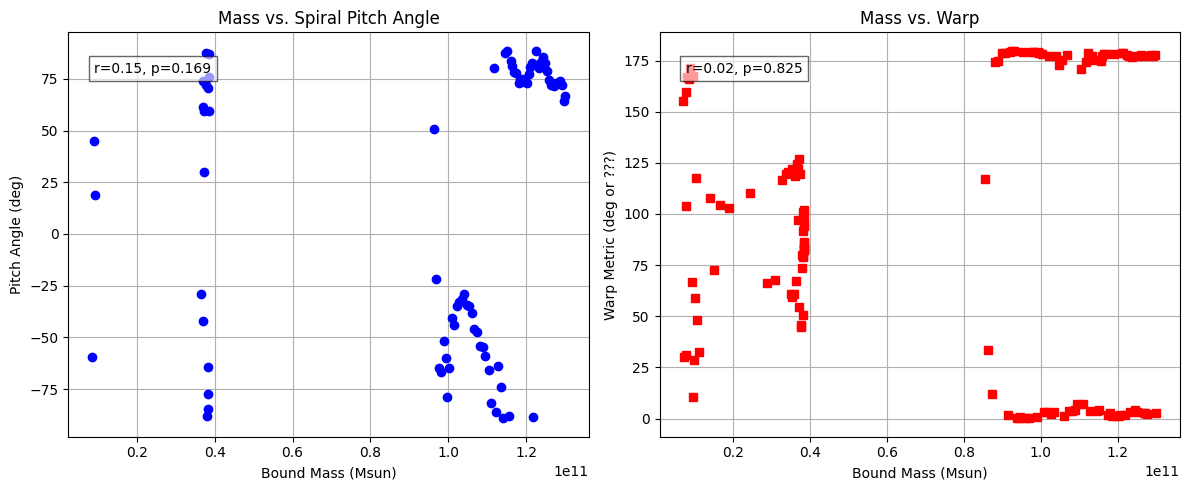


Cross-correlation plots for mass vs. morphology complete.

Hybrid pipeline: computed pitch + warp + cross-correlations with mass done.


In [35]:
####################################################################
# 1) Function to compute spiral pitch timeseries
####################################################################

def compute_spiral_pitch_timeseries(
    rmin=1.0, 
    rmax=15.0, 
    filter_disk=True, 
    disk_type=2,
    min_points_for_spiral=20,
    save_results=False
):
    """
    Loops over M33 snapshots to measure spiral pitch angle at each time,
    returning (times_spiral, pitch_arr). 
    If any snapshot doesn't meet min_points_for_spiral, 
    we fallback to NaN or 0.0, depending on measure_spiral_pitch_angle logic.

    Returns
    -------
    times_spiral : np.ndarray
    pitch_arr    : np.ndarray
    """
    import glob
    import logging
    import os

    m33_files = sorted(glob.glob(f"{M33_DIRECTORY}M33_*.txt"))
    if len(m33_files) == 0:
        logging.warning("No M33 files found for spiral pitch timeseries.")
        return np.array([]), np.array([])

    times_list  = []
    pitch_list  = []

    for f in m33_files:
        snap_idx = get_snapshot_index(f)
        if snap_idx is None:
            continue

        t_m33, count_m33, data_m33 = parse_galaxy_file(f)
        (ptype, mass, x, y, z, vx, vy, vz) = data_m33

        # shift M33
        xcom, ycom, zcom = center_of_mass(x, y, z, mass)
        x_shift = x - xcom
        y_shift = y - ycom
        z_shift = z - zcom
        vx_shift = vx
        vy_shift = vy
        vz_shift = vz

        if filter_disk:
            disk_mask = (ptype == disk_type)
            x_shift = x_shift[disk_mask]
            y_shift = y_shift[disk_mask]
            z_shift = z_shift[disk_mask]
            vx_shift = vx_shift[disk_mask]
            vy_shift = vy_shift[disk_mask]
            vz_shift = vz_shift[disk_mask]

        # if too few
        if len(x_shift) < min_points_for_spiral:
            pitch_list.append(np.nan)
            times_list.append(t_m33)
            logging.info(f"Snapshot {snap_idx}: <{min_points_for_spiral} disk pts => pitch=NaN.")
            continue

        # rotate
        pos_arr = np.column_stack((x_shift, y_shift, z_shift))
        vel_arr = np.column_stack((vx_shift, vy_shift, vz_shift))
        pos_rot, vel_rot = rotate_frame(pos_arr, vel_arr)

        # measure spiral pitch angle
        pitch_deg, theta0_best, m_best = measure_spiral_pitch_angle(pos_rot, rmin=rmin, rmax=rmax)
        pitch_list.append(pitch_deg)
        times_list.append(t_m33)

        logging.info(f"Snapshot {snap_idx}: time={t_m33:.2f} => pitch={pitch_deg:.2f} deg")

    times_spiral = np.array(times_list)
    pitch_arr    = np.array(pitch_list)
    idx = np.argsort(times_spiral)
    times_spiral = times_spiral[idx]
    pitch_arr    = pitch_arr[idx]

    if save_results and len(times_spiral)>0:
        os.makedirs(RESULTS_DIRECTORY, exist_ok=True)
        outfile = os.path.join(RESULTS_DIRECTORY, "spiral_pitch_vs_time.npy")
        np.save(outfile, np.column_stack((times_spiral, pitch_arr)))
        logging.info(f"Spiral pitch results saved to {outfile}")

    return times_spiral, pitch_arr


####################################################################
# 2) Function to compute a single warp metric per snapshot
####################################################################

def compute_warp_over_time(
    nbins=5,
    rmax=30.0,
    filter_disk=True,
    disk_type=2,
    warp_mode="outer",
    min_particles_for_warp=10,
    save_results=False
):
    """
    Loops over M33 snapshots to measure warp angles vs. radius,
    then picks a single warp value (outer, mean, or max).
    Returns (times_warp, warp_values).
    """
    import glob
    import logging
    import os

    times_list = []
    warp_list  = []

    m33_files = sorted(glob.glob(f"{M33_DIRECTORY}M33_*.txt"))
    if len(m33_files)==0:
        logging.warning("No M33 files for warp timeseries.")
        return np.array([]), np.array([])

    for f in m33_files:
        snap_idx = get_snapshot_index(f)
        if snap_idx is None:
            continue

        t_m33, count_m33, data_m33 = parse_galaxy_file(f)
        (ptype, mass, x, y, z, vx, vy, vz) = data_m33

        xcom, ycom, zcom = center_of_mass(x, y, z, mass)
        x_shift = x - xcom
        y_shift = y - ycom
        z_shift = z - zcom

        vx_shift = vx
        vy_shift = vy
        vz_shift = vz

        if filter_disk:
            disk_mask = (ptype == disk_type)
            x_shift = x_shift[disk_mask]
            y_shift = y_shift[disk_mask]
            z_shift = z_shift[disk_mask]
            vx_shift = vx_shift[disk_mask]
            vy_shift = vy_shift[disk_mask]
            vz_shift = vz_shift[disk_mask]

        if len(x_shift) < min_particles_for_warp:
            times_list.append(t_m33)
            warp_list.append(np.nan)
            logging.info(f"Snapshot {snap_idx}: <{min_particles_for_warp} disk pts => warp=NaN.")
            continue

        pos_arr = np.column_stack((x_shift, y_shift, z_shift))
        vel_arr = np.column_stack((vx_shift, vy_shift, vz_shift))
        pos_rot, vel_rot = rotate_frame(pos_arr, vel_arr)

        r_mid, warp_arr = measure_warp_angles(pos_rot, nbins=nbins, rmax=rmax)

        valid_mask = ~np.isnan(warp_arr)
        valid_warps = warp_arr[valid_mask]
        if len(valid_warps)==0:
            chosen_warp = np.nan
        else:
            if warp_mode=="outer":
                # last valid bin
                last_idx = np.where(valid_mask)[0][-1]
                chosen_warp = warp_arr[last_idx]
            elif warp_mode=="mean":
                chosen_warp = np.nanmean(valid_warps)
            elif warp_mode=="max":
                chosen_warp = np.nanmax(valid_warps)
            else:
                chosen_warp = valid_warps[-1]

        times_list.append(t_m33)
        warp_list.append(chosen_warp)
        logging.info(f"Snap {snap_idx} time={t_m33:.2f} => warp={chosen_warp:.2f} deg ({warp_mode})")

    # sort by time
    times_warp = np.array(times_list)
    warp_values = np.array(warp_list)
    idx_sort = np.argsort(times_warp)
    times_warp  = times_warp[idx_sort]
    warp_values = warp_values[idx_sort]

    if save_results and len(times_warp)>0:
        os.makedirs(RESULTS_DIRECTORY, exist_ok=True)
        outfile = os.path.join(RESULTS_DIRECTORY, "warp_vs_time.npy")
        np.save(outfile, np.column_stack((times_warp, warp_values)))
        logging.info(f"Warp timeseries saved to {outfile}")

    return times_warp, warp_values

####################################################################
# 3) CROSS CORRELATION USAGE
####################################################################

# Suppose we have from mass computations:
# times_bound, Mbound_arr  # e.g. from "Cell 3.2.2"
# Now we do:

# 1) get spiral pitch
times_spiral, pitch_arr = compute_spiral_pitch_timeseries(
    rmin=1.0,
    rmax=15.0,
    filter_disk=True,
    disk_type=2,
    min_points_for_spiral=20,
    save_results=True
)

# 2) get warp
times_warp, warp_values = compute_warp_over_time(
    nbins=5,
    rmax=30.0,
    filter_disk=True,
    disk_type=2,
    warp_mode="outer",
    min_particles_for_warp=10,
    save_results=True
)

# 3) cross-correlation: mass vs. pitch and mass vs. warp
cross_correlation_plots(
    times_bound, Mbound_arr,
    times_spiral, pitch_arr,
    times_warp, warp_values,
    outfig="mass_vs_pitch_and_warp.png"
)

print("Hybrid pipeline: computed pitch + warp + cross-correlations with mass done.")


In [36]:
# ---------------------------------------------------------------
# Cell 6.2 — "Final Data Tables & Logging Info"
# Type: Code
# ---------------------------------------------------------------
import pandas as pd
import numpy as np

def assemble_final_summary(times_bound, Mbound_arr,
                           times_jacobi=None, rjacobi_arr=None,
                           sersic_fits=None, exp_fits=None,
                           spiral_times=None, pitch_arr=None,
                           outcsv="m33_final_summary.csv"):
    """
    Combine major results into one final CSV table:
      columns: time, Mbound, R_j, Re, n, scale_length, pitch, etc.
    We'll do nearest-time matching or direct indexing as possible.

    For a more robust solution, each set of times can be interpolated onto a common time grid.
    For simplicity, we'll do a naive approach: for each time in times_bound, 
    we'll find the closest time in the other arrays.

    Then we save to CSV for referencing in the final paper.

    Parameters
    ----------
    times_bound, Mbound_arr : np.ndarray
        from measure_bound_mass
    times_jacobi, rjacobi_arr : np.ndarray or None
        from compute_jacobi_all_snaps
    sersic_fits, exp_fits : dict or None
        from run_fits_for_all_snapshots => snap_idx -> (t_val, param...)
    spiral_times, pitch_arr : np.ndarray or None
        from compute_spiral_pitch_timeseries
    outcsv : str
        path to save final summary

    Returns
    -------
    df_summary : pd.DataFrame
    """
    # We'll create a DataFrame from times_bound as the baseline
    df = pd.DataFrame({"time": times_bound, "Mbound": Mbound_arr})

    # If times_jacobi is not None, match them
    if times_jacobi is not None and rjacobi_arr is not None and len(times_jacobi)==len(rjacobi_arr)>0:
        # naive matching
        Rjac_matched = []
        for t_b in times_bound:
            idx = np.argmin(np.abs(times_jacobi - t_b))
            Rjac_matched.append(rjacobi_arr[idx])
        df["Rjacobi"] = Rjac_matched
    else:
        df["Rjacobi"] = np.nan

    # If sersic_fits is provided, we can do a similar approach or store by snapshot index
    # We know times_bound is sorted by snapshot index in a naive approach.
    # But a robust solution might require we re-check. We'll do naive approach:
    if sersic_fits is not None:
        Re_list, n_list = [], []
        # We'll do a direct approach: for each time in df, find closest snapshot in sersic_fits by time
        # build a list of (snap_idx, (time, Sigma_e, Re, n))
        # we can flatten sersic_fits into arrays
        s_snap = sorted(sersic_fits.keys())
        s_times = np.array([sersic_fits[s][0] for s in s_snap])
        revals  = np.array([sersic_fits[s][2] for s in s_snap])
        nvals   = np.array([sersic_fits[s][3] for s in s_snap])

        for t_b in df["time"]:
            idx = np.argmin(np.abs(s_times - t_b))
            Re_list.append(revals[idx])
            n_list.append(nvals[idx])
        df["Re_sersic"] = Re_list
        df["n_sersic"]  = n_list
    else:
        df["Re_sersic"] = np.nan
        df["n_sersic"]  = np.nan

    # If exp_fits is provided, do same approach
    if exp_fits is not None:
        h_list = []
        s_snap = sorted(exp_fits.keys())
        s_times = np.array([exp_fits[s][0] for s in s_snap])
        hvals   = np.array([exp_fits[s][2] for s in s_snap])  # index=2 => h, since (time, Sigma0, h)
        for t_b in df["time"]:
            idx = np.argmin(np.abs(s_times - t_b))
            h_list.append(hvals[idx])
        df["h_exp"] = h_list
    else:
        df["h_exp"] = np.nan

    # Spiral pitch
    if spiral_times is not None and pitch_arr is not None and len(spiral_times)>0:
        pitch_matched = []
        for t_b in df["time"]:
            idx = np.argmin(np.abs(spiral_times - t_b))
            pitch_matched.append(pitch_arr[idx])
        df["pitch_deg"] = pitch_matched
    else:
        df["pitch_deg"] = np.nan

    # Now we can store final table
    os.makedirs(RESULTS_DIRECTORY, exist_ok=True)
    outpath = os.path.join(RESULTS_DIRECTORY, outcsv)
    df.to_csv(outpath, index=False)
    logging.info(f"Final summary CSV saved to {outpath}")

    return df


# Example usage for a final summary table
df_summary = assemble_final_summary(times_bound, Mbound_arr,
                                    times_jacobi, rjacobi_arr,
                                    sersic_fits, exp_fits,
                                    times_spiral, pitch_arr,
                                    outcsv="m33_final_summary.csv")
df_summary.head(10)

print("Cell 6.2 completed: final summary table assembled & saved.")


2025-04-01 12:42:53,630 [INFO] Final summary CSV saved to results/m33_final_summary.csv
Cell 6.2 completed: final summary table assembled & saved.
